In [1]:
## new models with new data pre-processing
### binary prediction : (user features) -> Pr(response)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import cPickle as pickle
import numpy as np
import pandas as pd
import os

import sys
sys.path.append('../../')
from target_pred import FCModel, RNNModel, XGBoostModel, create_sets, evaluate
from target_pred import prepare_trns, report_softmax, leave_one_out, KFoldTargetEncoding, HypeNKFoldCV, targetEncoding
import cPickle as pickle
import numpy as np
import pandas as pd
import os

from joblib import Parallel, delayed

import sklearn
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import cross_validation, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, auc, roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.svm import SVC

from random import sample
from tqdm import tqdm
from scipy import interp

from collections import Counter, defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.image as image
from IPython.display import Image

import xgboost as xgb_lib
from io import BytesIO

import re

import warnings
warnings.filterwarnings("ignore")

/home/drsleep/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
def plot_ROC_curve(classifier, X, y, pos_label=1, n_folds=5):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train, test) in enumerate(StratifiedKFold(y, n_folds=n_folds)):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.4f)' % (i, roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    mean_tpr /= n_folds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.4f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def plot_PR_curve(classifier, X, y, n_folds=5):
    """
    Plot a basic precision/recall curve.
    """
    for i, (train, test) in enumerate(StratifiedKFold(y, n_folds=n_folds)):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        precision, recall, thresholds = metrics.precision_recall_curve(y[test], probas_[:, 1],
                                                               pos_label=1)
        plt.plot(recall, precision, lw=1, label='PR fold %d' % (i,))
   #  clf_name = str(type(classifier))
   # clf_name = clf_name[clf_name.rindex('.')+1:]
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-recall curve')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
from string import letters
import seaborn as sns

def corr_matrix(d, figsize = (15, 15)):
    sns.set(style="white")

    # Compute the correlation matrix
    corr = d.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                square=True, #xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

## Binary Model: (response / no response)

### XGBoost

In [6]:
file_path = '../../../../../../../Documents/projects/new_data/BB/CD_ALL_2017-07-06.csv'
df_usual = pd.read_csv(file_path, sep='>', nrows=20)

In [95]:
ignore_cols = [
 'CLIENT_ID',
 'CONTRACT_REF',
# 'CONTROL_GROUP_FLG',
 'BANK',
 'SCENARIO_NAME_UNI',
 'START_DATE',
 'label',
#  'IS_LOYALTY_AUTO',
#  'IS_LOYALTY_BEAUTY',
#  'IS_LOYALTY_ONLINE',
#  'IS_LOYALTY_TRAVEL',
#  'IS_LOYALTY_WEEKEND',
  ]

ignore_cols_binning = [
 'CLIENT_ID',
 'CONTRACT_REF',
 'CONTROL_GROUP_FLG',
 'BANK',
 'SCENARIO_NAME_UNI',
 'START_DATE',
 'label',
 'IS_LOYALTY_AUTO',
 'IS_LOYALTY_BEAUTY',
 'IS_LOYALTY_ONLINE',
 'IS_LOYALTY_TRAVEL',
 'IS_LOYALTY_WEEKEND',
  ]

drop_cols = [ 
 'CLIENT_ID',
 'CONTRACT_REF',
 'BANK',
 'SCENARIO_NAME_UNI',
 'START_DATE',
 'LAST_CARD_STATUS_DT',
 'LAST_CONTR_STATUS_DT']

scaler = 'standard'
dummy_config = (15, 0.9)
fill_na = False
n_bins = 5
seed = 42
test_size = 0.15

In [96]:
Xy_train, Xy_test, _, _, _  = create_sets(path_to_file=file_path,
                                          sep='>',
                                          ignore_cols_dummy=ignore_cols,
                                          ignore_cols_norm=ignore_cols + ['CONTROL_GROUP_FLG'],
                                          ignore_cols_binning=ignore_cols_binning,
                                          drop_cols=drop_cols,
                                          dummy_config=dummy_config,
                                          fill_na=fill_na,
                                          scaler=scaler,
                                          n_bins=n_bins,
                                          transform_dict=None,
                                          normalise_dict=None,
                                          binning_dict=None,
                                          test_size=test_size,
                                          seed=seed,
                                          verbose=False)

In [97]:
binned_columns = filter(lambda x: 'BINNED' in x, Xy_train.columns)

In [114]:
n_trials = 50
nfolds = 5
kfolds = 5
target_col = 'label'

param_dict = defaultdict(list)

for i in tqdm(range(n_trials)):
    alpha = np.random.uniform(low=8, high=15)
    n_estimators = np.random.randint(low=80, high=120)
    learning_rate = np.random.uniform(low=1e-5, high=5e-1)
    subsample = np.random.uniform(low=0.7, high=0.9)
    c_config = dict(max_depth=5, learning_rate=learning_rate, 
                    n_estimators=n_estimators, seed=seed,
                                 reg_lambda=450, scale_pos_weight=1.15, nthread=4, missing=np.nan,
                                 reg_alpha=200, subsample=subsample)
    c_model = XGBoostModel(c_config)
    
    
    val_res = HypeNKFoldCV(Xy_train,
                           binned_columns,
                           target_col,
                           c_model,
                           nfolds,
                           kfolds,
                           alpha,
                           noise_std=0.000695,
                           scorer=f1_score
                          )
    param_dict['alpha'].append(alpha)
    #param_dict['noise_std'].append(noise_std)
    param_dict['val_res'].append(val_res)
    param_dict['n_estimators'].append(n_estimators)
    param_dict['subsample'].append(subsample)
    param_dict['learning_rate'].append(learning_rate)

100%|██████████| 50/50 [47:42<00:00, 62.35s/it]


In [115]:
param_df = pd.DataFrame(param_dict)

In [116]:
param_df['cv_score'] = param_df['val_res'].apply(np.mean)

In [117]:
param_df.drop('val_res', axis=1).sort_values('cv_score', ascending=False)

,alpha,learning_rate,n_estimators,subsample,cv_score
9,12.363347,0.185550,95,0.770781,0.836929
8,9.026899,0.259688,116,0.722347,0.836577
10,10.488842,0.223491,111,0.774856,0.836294
42,12.997223,0.052232,83,0.892856,0.835757
15,12.803614,0.202766,88,0.765736,0.835728
27,8.139936,0.053703,99,0.724030,0.835640
48,8.162796,0.420021,110,0.744021,0.835519
49,13.668117,0.071461,108,0.707132,0.835156
18,12.794239,0.113642,82,0.856207,0.835036
17,10.317036,0.199409,107,0.806460,0.834939


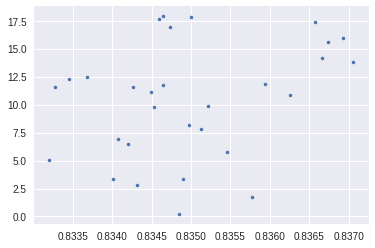

In [113]:
plt.plot(param_df['cv_score'], param_df['alpha'], '.')

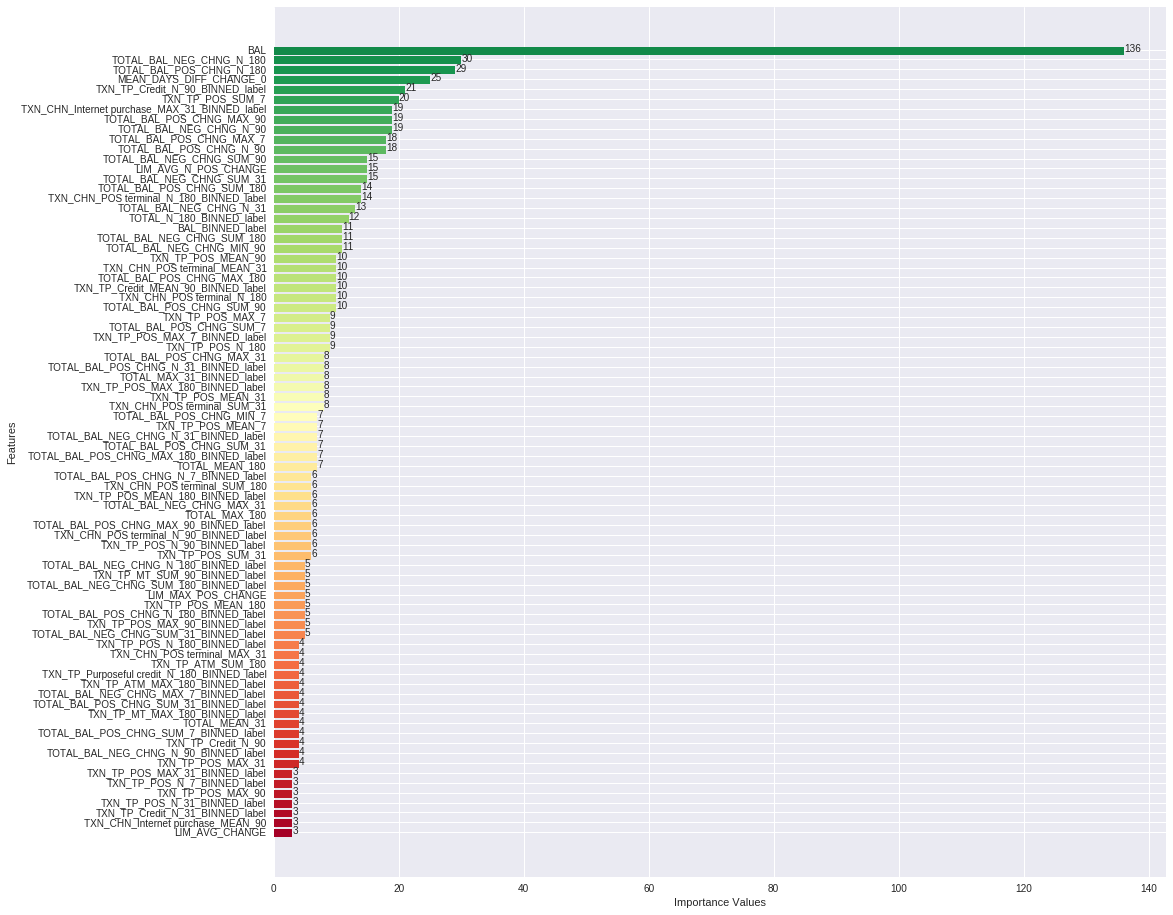

In [118]:
importances = c_model.xgb.booster().get_fscore()
f_names, f_values = zip(*sorted(importances.items(), key=lambda x: x[1]))

st_idx = len(f_names) / 2; end_idx = len(f_names) / 1;

fig = plt.figure(figsize=(16, 16))
plt.barh(np.arange(len(f_names[st_idx : end_idx])), f_values[st_idx : end_idx],
         color=[cm.RdYlGn(i * 3) for i in range(len(f_names[st_idx : end_idx]))])
fig.axes[0].set_yticklabels(f_names[st_idx : end_idx])
fig.axes[0].set_yticks(np.arange(len(f_names[st_idx : end_idx])) + 0.1)
fig.axes[0].set_xlabel('Importance Values')
fig.axes[0].set_ylabel('Features')
fig.axes[0].set_label('Feature Importances')
for i, v in enumerate(f_values[st_idx : end_idx]):
    fig.axes[0].text(v + .02, i - 0.1, v)
plt.show()

In [50]:
best_alpha = 8.403863
best_noise_std = 0.000695

In [56]:
## encode all Xy_train
## all indices
all_idx = Xy_train.index.copy().values
np.random.shuffle(all_idx)
## outer splits indices
outer_splits = np.array_split(all_idx, nfolds)
for c_col in binned_columns:
    n_col_name = '_'.join([c_col, target_col])
    Xy_train[n_col_name] = KFoldTargetEncoding(Xy_train[[c_col, target_col]],
                                               outer_splits,
                                               c_col,
                                               target_col,
                                               n_col_name,
                                               best_alpha,
                                               best_noise_std)
    Xy_test[n_col_name] = targetEncoding(Xy_train[[c_col, target_col]],
                                         Xy_test[[c_col]],
                                         c_col,
                                         target_col,
                                         best_alpha,
                                         best_noise_std)

In [59]:
c_config = dict(max_depth=5, learning_rate=.075, n_estimators=140, seed=seed,
                                 reg_lambda=950, scale_pos_weight=1.15, nthread=4, missing=np.nan,
                                 reg_alpha=500, subsample=0.7)

In [74]:
drop_cols_binned = ['label'] + filter(lambda x: re.match(u'.*_BINNED$', x), Xy_train.columns)
drop_cols_binned_target = ['label'] + filter(lambda x: re.match(u'.*_BINNED', x), Xy_train.columns)
drop_cols_y = ['label']
keep_target = filter(lambda x: re.match(u'.*_label', x), Xy_train.columns)

In [85]:
train_preds = []
test_preds = []

## no binned, no target
c_model_orig = XGBoostModel(c_config)
c_model_orig.train(Xy_train.drop(drop_cols_binned_target, axis=1), Xy_train.label)
train_preds.append(c_model_orig.test(Xy_train.drop(drop_cols_binned_target, axis=1)))
test_preds.append(c_model_orig.test(Xy_test.drop(drop_cols_binned_target, axis=1)))

## no binned
c_model_no_binned = XGBoostModel(c_config)
c_model_no_binned.train(Xy_train.drop(drop_cols_binned, axis=1), Xy_train.label)
train_preds.append(c_model_no_binned.test(Xy_train.drop(drop_cols_binned, axis=1)))
test_preds.append(c_model_no_binned.test(Xy_test.drop(drop_cols_binned, axis=1)))

## just target
c_model_target = XGBoostModel(c_config)
c_model_target.train(Xy_train[keep_target], Xy_train.label)
train_preds.append(c_model_target.test(Xy_train[keep_target]))
test_preds.append(c_model_target.test(Xy_test[keep_target]))

## all
c_model_all = XGBoostModel(c_config)
c_model_all.train(Xy_train.drop(drop_cols_y, axis=1), Xy_train.label)
train_preds.append(c_model_all.test(Xy_train.drop(drop_cols_y, axis=1)))
test_preds.append(c_model_all.test(Xy_test.drop(drop_cols_y, axis=1)))

In [86]:
evaluate(test_preds, Xy_test.label, 
         './BB', file_prefix='test_ens_enc', model_names=['orig', 'no_binned', 'target', 'all'])
evaluate(train_preds, Xy_train.label, 
         './BB', file_prefix='train_ens_enc', model_names=['orig', 'no_binned', 'target', 'all'])

### FC

In [8]:
file_path = '../../../../../../../Documents/projects/new_data/BB/CD_ALL_2017-07-06.csv'
df_usual = pd.read_csv(file_path, sep='>', nrows=20)

In [9]:
ignore_cols = [
 'CLIENT_ID',
 'CONTRACT_REF',
# 'CONTROL_GROUP_FLG',
 'BANK',
 'SCENARIO_NAME_UNI',
 'START_DATE',
 'label',
#  'IS_LOYALTY_AUTO',
#  'IS_LOYALTY_BEAUTY',
#  'IS_LOYALTY_ONLINE',
#  'IS_LOYALTY_TRAVEL',
#  'IS_LOYALTY_WEEKEND',
  ]

ignore_cols_binning = [
 'CLIENT_ID',
 'CONTRACT_REF',
 'CONTROL_GROUP_FLG',
 'BANK',
 'SCENARIO_NAME_UNI',
 'START_DATE',
 'label',
 'IS_LOYALTY_AUTO',
 'IS_LOYALTY_BEAUTY',
 'IS_LOYALTY_ONLINE',
 'IS_LOYALTY_TRAVEL',
 'IS_LOYALTY_WEEKEND',
  ]

drop_cols = [ 
 'CLIENT_ID',
 'CONTRACT_REF',
 'BANK',
 'SCENARIO_NAME_UNI',
 'START_DATE',
 'LAST_CARD_STATUS_DT',
 'LAST_CONTR_STATUS_DT']

scaler = 'standard'
dummy_config = (15, 0.9)
fill_na = True
n_bins = 7
seed = 42
test_size = 0.15

In [10]:
Xy_train, Xy_test, _, _, _  = create_sets(path_to_file=file_path,
                                          sep='>',
                                          ignore_cols_dummy=ignore_cols,
                                          ignore_cols_norm=ignore_cols + ['CONTROL_GROUP_FLG'],
                                          ignore_cols_binning=ignore_cols_binning,
                                          drop_cols=drop_cols,
                                          dummy_config=dummy_config,
                                          fill_na=fill_na,
                                          scaler=scaler,
                                          n_bins=n_bins,
                                          transform_dict=None,
                                          normalise_dict=None,
                                          binning_dict=None,
                                          test_size=test_size,
                                          seed=seed,
                                          verbose=False)

In [14]:
binned_columns = filter(lambda x: 'BINNED' in x, Xy_train.columns)

In [ ]:
n_trials = 500
nfolds = 5
kfolds = 5
target_col = 'label'

param_dict = defaultdict(list)

for i in tqdm(range(n_trials)):
    best_alpha = 8.403863
    best_noise_std = 0.000695
    n_layers = np.random.randint(low=1, high=4)
    n_hidden = np.random.randint(low=128, high=384, size=n_layers)
    learning_rate = np.random.uniform(low=1e-5, high=9e-3)
    weight_decay = np.random.uniform(low=5e-5, high=5e-2)
    batch_size = np.random.randint(low=16, high=128)
    fc_config = dict(learning_rate=learning_rate,
                     n_hidden=n_hidden,
                     weight_decay=weight_decay,
                     n_input=(Xy_train.shape[1] - 1) + len(binned_columns),
                     n_output=2,
                     n_iters=10001,
                     batch_size=batch_size,
                     seed=seed
                     )
    fc_model = FCModel(fc_config)
    val_res = HypeNKFoldCV(Xy_train,
                           binned_columns,
                           target_col,
                           fc_model,
                           nfolds,
                           kfolds,
                           best_alpha,
                           best_noise_std,
                           scorer=f1_score
                          )
    param_dict['n_layers'].append(n_layers)
    param_dict['n_hidden'].append(n_hidden)
    param_dict['weight_decay'].append(weight_decay)
    param_dict['batch_size'].append(batch_size)
    param_dict['val_res'].append(val_res)
    param_dict['learning_rate'].append(learning_rate)

  0%|          | 0/500 [00:00<?, ?it/s]

Loss after 5000 iter. : 0.3418
Loss after 10000 iter. : 0.4339
Loss after 5000 iter. : 0.5565
Loss after 10000 iter. : 0.2913
Loss after 5000 iter. : 0.4509
Loss after 10000 iter. : 0.4392
Loss after 5000 iter. : 0.4330
Loss after 10000 iter. : 0.2915
Loss after 5000 iter. : 0.5860


  0%|          | 1/500 [08:01<66:41:50, 481.18s/it]

Loss after 10000 iter. : 0.3621
Loss after 5000 iter. : 0.4896
Loss after 10000 iter. : 0.4074
Loss after 5000 iter. : 0.3991
Loss after 10000 iter. : 0.2012
Loss after 5000 iter. : 0.5252
Loss after 10000 iter. : 0.5618
Loss after 5000 iter. : 0.3319
Loss after 10000 iter. : 0.4514
Loss after 5000 iter. : 0.3947


  0%|          | 2/500 [11:00<54:03:13, 390.75s/it]

Loss after 10000 iter. : 0.3827
Loss after 5000 iter. : 0.3397
Loss after 10000 iter. : 0.5094
Loss after 5000 iter. : 0.5746
Loss after 10000 iter. : 0.4331
Loss after 5000 iter. : 0.3433
Loss after 10000 iter. : 0.4459
Loss after 5000 iter. : 0.3733
Loss after 10000 iter. : 0.6015
Loss after 5000 iter. : 0.5106


  1%|          | 3/500 [14:59<47:39:22, 345.20s/it]

Loss after 10000 iter. : 0.5261
Loss after 5000 iter. : 0.5303
Loss after 10000 iter. : 0.5210
Loss after 5000 iter. : 0.4924
Loss after 10000 iter. : 0.4889
Loss after 5000 iter. : 0.3842
Loss after 10000 iter. : 0.4066
Loss after 5000 iter. : 0.3692
Loss after 10000 iter. : 0.4629
Loss after 5000 iter. : 0.4044


  1%|          | 4/500 [20:12<46:13:41, 335.53s/it]

Loss after 10000 iter. : 0.4339
Loss after 5000 iter. : 0.3608
Loss after 10000 iter. : 0.2924
Loss after 5000 iter. : 0.3527
Loss after 10000 iter. : 0.2511
Loss after 5000 iter. : 0.4605
Loss after 10000 iter. : 0.4394
Loss after 5000 iter. : 0.2966
Loss after 10000 iter. : 0.3603
Loss after 5000 iter. : 0.2681


  1%|          | 5/500 [28:57<53:56:01, 392.25s/it]

Loss after 10000 iter. : 0.2852
Loss after 5000 iter. : 0.3279
Loss after 10000 iter. : 0.3939
Loss after 5000 iter. : 0.3241
Loss after 10000 iter. : 0.2382
Loss after 5000 iter. : 0.4275
Loss after 10000 iter. : 0.4705
Loss after 5000 iter. : 0.7597
Loss after 10000 iter. : 0.4156
Loss after 5000 iter. : 0.3325


  1%|          | 6/500 [35:15<53:13:45, 387.91s/it]

Loss after 10000 iter. : 0.2913
Loss after 5000 iter. : 0.2994
Loss after 10000 iter. : 0.2108
Loss after 5000 iter. : 0.4760
Loss after 10000 iter. : 0.3011
Loss after 5000 iter. : 0.5816
Loss after 10000 iter. : 0.3325
Loss after 5000 iter. : 0.3973
Loss after 10000 iter. : 0.5417
Loss after 5000 iter. : 0.3723


  1%|▏         | 7/500 [40:05<49:07:54, 358.77s/it]

Loss after 10000 iter. : 0.4288
Loss after 5000 iter. : 0.4103
Loss after 10000 iter. : 0.4303
Loss after 5000 iter. : 0.4186
Loss after 10000 iter. : 0.3774
Loss after 5000 iter. : 0.4790
Loss after 10000 iter. : 0.3637
Loss after 5000 iter. : 0.4694
Loss after 10000 iter. : 0.4436
Loss after 5000 iter. : 0.3463


  2%|▏         | 8/500 [49:08<56:33:44, 413.87s/it]

Loss after 10000 iter. : 0.4483
Loss after 5000 iter. : 0.3852
Loss after 10000 iter. : 0.4105
Loss after 5000 iter. : 0.4231
Loss after 10000 iter. : 0.3354
Loss after 5000 iter. : 0.3201
Loss after 10000 iter. : 0.4111
Loss after 5000 iter. : 0.3554
Loss after 10000 iter. : 0.3725
Loss after 5000 iter. : 0.4192


  2%|▏         | 9/500 [55:21<54:46:42, 401.63s/it]

Loss after 10000 iter. : 0.3705
Loss after 5000 iter. : 0.2854
Loss after 10000 iter. : 0.2505
Loss after 5000 iter. : 0.3501
Loss after 10000 iter. : 0.5125
Loss after 5000 iter. : 0.4073
Loss after 10000 iter. : 0.3243
Loss after 5000 iter. : 0.3483
Loss after 10000 iter. : 0.3414
Loss after 5000 iter. : 0.3766


  2%|▏         | 10/500 [1:02:42<56:17:29, 413.57s/it]

Loss after 10000 iter. : 0.6004
Loss after 5000 iter. : 0.4932
Loss after 10000 iter. : 0.5474
Loss after 5000 iter. : 0.4006
Loss after 10000 iter. : 0.5514
Loss after 5000 iter. : 0.5607
Loss after 10000 iter. : 0.5354
Loss after 5000 iter. : 0.5480
Loss after 10000 iter. : 0.4901
Loss after 5000 iter. : 0.4574


  2%|▏         | 11/500 [1:08:33<53:35:35, 394.55s/it]

Loss after 10000 iter. : 0.3647
Loss after 5000 iter. : 0.3573
Loss after 10000 iter. : 0.3612
Loss after 5000 iter. : 0.4485
Loss after 10000 iter. : 0.4536
Loss after 5000 iter. : 0.4053
Loss after 10000 iter. : 0.4282
Loss after 5000 iter. : 0.4070
Loss after 10000 iter. : 0.3561
Loss after 5000 iter. : 0.4632


  2%|▏         | 12/500 [1:13:55<50:32:11, 372.81s/it]

Loss after 10000 iter. : 0.3284
Loss after 5000 iter. : 0.5033
Loss after 10000 iter. : 0.4802
Loss after 5000 iter. : 0.3839
Loss after 10000 iter. : 0.2786
Loss after 5000 iter. : 0.4479
Loss after 10000 iter. : 0.3623
Loss after 5000 iter. : 0.3776
Loss after 10000 iter. : 0.3417
Loss after 5000 iter. : 0.3996


  3%|▎         | 13/500 [1:22:27<56:05:28, 414.64s/it]

Loss after 10000 iter. : 0.3982
Loss after 5000 iter. : 0.4038
Loss after 10000 iter. : 0.4601
Loss after 5000 iter. : 0.3887
Loss after 10000 iter. : 0.3700
Loss after 5000 iter. : 0.4382
Loss after 10000 iter. : 0.4947
Loss after 5000 iter. : 0.3062
Loss after 10000 iter. : 0.4571
Loss after 5000 iter. : 0.5100


  3%|▎         | 14/500 [1:29:27<56:11:21, 416.22s/it]

Loss after 10000 iter. : 0.3225
Loss after 5000 iter. : 0.5801
Loss after 10000 iter. : 0.3748
Loss after 5000 iter. : 0.4090
Loss after 10000 iter. : 0.4617
Loss after 5000 iter. : 0.3662
Loss after 10000 iter. : 0.5822
Loss after 5000 iter. : 0.3772
Loss after 10000 iter. : 0.4724
Loss after 5000 iter. : 0.4682


  3%|▎         | 15/500 [1:36:02<55:14:28, 410.04s/it]

Loss after 10000 iter. : 0.4576
Loss after 5000 iter. : 0.4232
Loss after 10000 iter. : 0.2615
Loss after 5000 iter. : 0.4110
Loss after 10000 iter. : 0.4692
Loss after 5000 iter. : 0.3600
Loss after 10000 iter. : 0.5192
Loss after 5000 iter. : 0.6212
Loss after 10000 iter. : 0.5134
Loss after 5000 iter. : 0.4523


  3%|▎         | 16/500 [1:44:31<59:06:41, 439.67s/it]

Loss after 10000 iter. : 0.3806
Loss after 5000 iter. : 0.4208
Loss after 10000 iter. : 0.3595
Loss after 5000 iter. : 0.4201
Loss after 10000 iter. : 0.4177
Loss after 5000 iter. : 0.3380
Loss after 10000 iter. : 0.4075
Loss after 5000 iter. : 0.4280
Loss after 10000 iter. : 0.4249
Loss after 5000 iter. : 0.5399


  3%|▎         | 17/500 [1:55:31<67:51:23, 505.76s/it]

Loss after 10000 iter. : 0.4391
Loss after 5000 iter. : 0.4143
Loss after 10000 iter. : 0.3469
Loss after 5000 iter. : 0.3652
Loss after 10000 iter. : 0.4137
Loss after 5000 iter. : 0.3259
Loss after 10000 iter. : 0.3521
Loss after 5000 iter. : 0.3677
Loss after 10000 iter. : 0.4797
Loss after 5000 iter. : 0.3044


  4%|▎         | 18/500 [2:02:47<64:54:17, 484.77s/it]

Loss after 10000 iter. : 0.3157
Loss after 5000 iter. : 0.5619
Loss after 10000 iter. : 0.3720
Loss after 5000 iter. : 0.4566
Loss after 10000 iter. : 0.4307
Loss after 5000 iter. : 0.4164
Loss after 10000 iter. : 0.3992
Loss after 5000 iter. : 0.3398
Loss after 10000 iter. : 0.4593
Loss after 5000 iter. : 0.2933


  4%|▍         | 19/500 [2:07:48<57:23:12, 429.51s/it]

Loss after 10000 iter. : 0.4521
Loss after 5000 iter. : 0.4997
Loss after 10000 iter. : 0.4534
Loss after 5000 iter. : 0.4604
Loss after 10000 iter. : 0.4287
Loss after 5000 iter. : 0.4066
Loss after 10000 iter. : 0.4833
Loss after 5000 iter. : 0.4679
Loss after 10000 iter. : 0.3475
Loss after 5000 iter. : 0.4305


  4%|▍         | 20/500 [2:15:07<57:39:17, 432.41s/it]

Loss after 10000 iter. : 0.4266
Loss after 5000 iter. : 0.4249
Loss after 10000 iter. : 0.3455
Loss after 5000 iter. : 0.3896
Loss after 10000 iter. : 0.3551
Loss after 5000 iter. : 0.4173
Loss after 10000 iter. : 0.4644
Loss after 5000 iter. : 0.4000
Loss after 10000 iter. : 0.3345
Loss after 5000 iter. : 0.4611


  4%|▍         | 21/500 [2:23:02<59:14:39, 445.26s/it]

Loss after 10000 iter. : 0.3777
Loss after 5000 iter. : 0.3752
Loss after 10000 iter. : 0.3651
Loss after 5000 iter. : 0.3913
Loss after 10000 iter. : 0.4317
Loss after 5000 iter. : 0.3157
Loss after 10000 iter. : 0.3398
Loss after 5000 iter. : 0.3526
Loss after 10000 iter. : 0.3231
Loss after 5000 iter. : 0.4356


  4%|▍         | 22/500 [2:28:24<54:12:08, 408.22s/it]

Loss after 10000 iter. : 0.3173
Loss after 5000 iter. : 0.6812
Loss after 10000 iter. : 0.3307
Loss after 5000 iter. : 0.3543
Loss after 10000 iter. : 0.4103
Loss after 5000 iter. : 0.6028
Loss after 10000 iter. : 0.6188
Loss after 5000 iter. : 0.3587
Loss after 10000 iter. : 0.3702
Loss after 5000 iter. : 0.3943


  5%|▍         | 23/500 [2:31:54<46:12:17, 348.72s/it]

Loss after 10000 iter. : 0.4379
Loss after 5000 iter. : 0.3890
Loss after 10000 iter. : 0.4599
Loss after 5000 iter. : 0.5008
Loss after 10000 iter. : 0.4566
Loss after 5000 iter. : 0.3829
Loss after 10000 iter. : 0.3093
Loss after 5000 iter. : 0.4722
Loss after 10000 iter. : 0.4697
Loss after 5000 iter. : 0.4100


  5%|▍         | 24/500 [2:42:11<56:45:19, 429.24s/it]

Loss after 10000 iter. : 0.3172
Loss after 5000 iter. : 0.4039
Loss after 10000 iter. : 0.5037
Loss after 5000 iter. : 0.3842
Loss after 10000 iter. : 0.2434
Loss after 5000 iter. : 0.4836
Loss after 10000 iter. : 0.4873
Loss after 5000 iter. : 0.4330
Loss after 10000 iter. : 0.4509
Loss after 5000 iter. : 0.3519


  5%|▌         | 25/500 [2:48:11<53:53:26, 408.43s/it]

Loss after 10000 iter. : 0.3973
Loss after 5000 iter. : 0.4642
Loss after 10000 iter. : 0.3621
Loss after 5000 iter. : 0.4603
Loss after 10000 iter. : 0.4592
Loss after 5000 iter. : 0.4497
Loss after 10000 iter. : 0.4235
Loss after 5000 iter. : 0.3689
Loss after 10000 iter. : 0.4861
Loss after 5000 iter. : 0.3886


  5%|▌         | 26/500 [2:58:11<61:21:13, 465.98s/it]

Loss after 10000 iter. : 0.4040
Loss after 5000 iter. : 0.2929
Loss after 10000 iter. : 0.3073
Loss after 5000 iter. : 0.4055
Loss after 10000 iter. : 0.3994
Loss after 5000 iter. : 0.2267
Loss after 10000 iter. : 0.2529
Loss after 5000 iter. : 0.3568
Loss after 10000 iter. : 0.2261
Loss after 5000 iter. : 0.2476


  5%|▌         | 27/500 [3:05:22<59:51:10, 455.54s/it]

Loss after 10000 iter. : 0.2698
Loss after 5000 iter. : 0.3901
Loss after 10000 iter. : 0.3923
Loss after 5000 iter. : 0.4142
Loss after 10000 iter. : 0.4976
Loss after 5000 iter. : 0.4181
Loss after 10000 iter. : 0.4893
Loss after 5000 iter. : 0.3544
Loss after 10000 iter. : 0.4389
Loss after 5000 iter. : 0.4662


  6%|▌         | 28/500 [3:13:31<61:03:04, 465.65s/it]

Loss after 10000 iter. : 0.4276
Loss after 5000 iter. : 0.3453
Loss after 10000 iter. : 0.3832
Loss after 5000 iter. : 0.3789
Loss after 10000 iter. : 0.3235
Loss after 5000 iter. : 0.4459
Loss after 10000 iter. : 0.3144
Loss after 5000 iter. : 0.5768
Loss after 10000 iter. : 0.4355
Loss after 5000 iter. : 0.3864


  6%|▌         | 29/500 [3:20:00<57:53:47, 442.52s/it]

Loss after 10000 iter. : 0.4764
Loss after 5000 iter. : 0.3744
Loss after 10000 iter. : 0.3249
Loss after 5000 iter. : 0.4325
Loss after 10000 iter. : 0.4077
Loss after 5000 iter. : 0.3951
Loss after 10000 iter. : 0.5370
Loss after 5000 iter. : 0.2861
Loss after 10000 iter. : 0.5635
Loss after 5000 iter. : 0.4597


  6%|▌         | 30/500 [3:25:28<53:18:05, 408.27s/it]

Loss after 10000 iter. : 0.4458
Loss after 5000 iter. : 0.3722
Loss after 10000 iter. : 0.4584
Loss after 5000 iter. : 0.4225
Loss after 10000 iter. : 0.4658
Loss after 5000 iter. : 0.3756
Loss after 10000 iter. : 0.4874
Loss after 5000 iter. : 0.4386
Loss after 10000 iter. : 0.4529
Loss after 5000 iter. : 0.4372


  6%|▌         | 31/500 [3:32:22<53:24:07, 409.91s/it]

Loss after 10000 iter. : 0.3839
Loss after 5000 iter. : 0.3727
Loss after 10000 iter. : 0.3157
Loss after 5000 iter. : 0.4532
Loss after 10000 iter. : 0.3656
Loss after 5000 iter. : 0.4507
Loss after 10000 iter. : 0.3023
Loss after 5000 iter. : 0.3784
Loss after 10000 iter. : 0.3321
Loss after 5000 iter. : 0.4784


  6%|▋         | 32/500 [3:42:20<60:37:57, 466.41s/it]

Loss after 10000 iter. : 0.3287
Loss after 5000 iter. : 0.4510
Loss after 10000 iter. : 0.4692
Loss after 5000 iter. : 0.4000
Loss after 10000 iter. : 0.3967
Loss after 5000 iter. : 0.3646
Loss after 10000 iter. : 0.3685
Loss after 5000 iter. : 0.4446
Loss after 10000 iter. : 0.3612
Loss after 5000 iter. : 0.4183


  7%|▋         | 33/500 [3:53:34<68:34:13, 528.59s/it]

Loss after 10000 iter. : 0.4214
Loss after 5000 iter. : 0.3576
Loss after 10000 iter. : 0.5600
Loss after 5000 iter. : 0.5105
Loss after 10000 iter. : 0.3376
Loss after 5000 iter. : 0.4015
Loss after 10000 iter. : 0.3518
Loss after 5000 iter. : 0.5973
Loss after 10000 iter. : 0.3369
Loss after 5000 iter. : 0.4754


  7%|▋         | 34/500 [4:00:10<63:16:44, 488.85s/it]

Loss after 10000 iter. : 0.4741
Loss after 5000 iter. : 0.3851
Loss after 10000 iter. : 0.3792
Loss after 5000 iter. : 0.5572
Loss after 10000 iter. : 0.3901
Loss after 5000 iter. : 0.2595
Loss after 10000 iter. : 0.3719
Loss after 5000 iter. : 0.4759
Loss after 10000 iter. : 0.3894
Loss after 5000 iter. : 0.4442


  7%|▋         | 35/500 [4:07:26<61:06:24, 473.09s/it]

Loss after 10000 iter. : 0.4166
Loss after 5000 iter. : 0.4504
Loss after 10000 iter. : 0.3313
Loss after 5000 iter. : 0.4089
Loss after 10000 iter. : 0.3576
Loss after 5000 iter. : 0.3672
Loss after 10000 iter. : 0.4196
Loss after 5000 iter. : 0.4789
Loss after 10000 iter. : 0.4224
Loss after 5000 iter. : 0.3329


  7%|▋         | 36/500 [4:16:22<63:24:45, 492.00s/it]

Loss after 10000 iter. : 0.4135
Loss after 5000 iter. : 0.4161
Loss after 10000 iter. : 0.4811
Loss after 5000 iter. : 0.4154
Loss after 10000 iter. : 0.3454
Loss after 5000 iter. : 0.3457
Loss after 10000 iter. : 0.3544
Loss after 5000 iter. : 0.5555
Loss after 10000 iter. : 0.3222
Loss after 5000 iter. : 0.5742


  7%|▋         | 37/500 [4:24:49<63:49:53, 496.31s/it]

Loss after 10000 iter. : 0.4242
Loss after 5000 iter. : 0.4571
Loss after 10000 iter. : 0.3872
Loss after 5000 iter. : 0.4112
Loss after 10000 iter. : 0.4242
Loss after 5000 iter. : 0.4529
Loss after 10000 iter. : 0.3973
Loss after 5000 iter. : 0.2812
Loss after 10000 iter. : 0.2984
Loss after 5000 iter. : 0.3943


  8%|▊         | 38/500 [4:29:13<54:45:15, 426.66s/it]

Loss after 10000 iter. : 0.4607
Loss after 5000 iter. : 0.3101
Loss after 10000 iter. : 0.4137
Loss after 5000 iter. : 0.4832
Loss after 10000 iter. : 0.3386
Loss after 5000 iter. : 0.4469
Loss after 10000 iter. : 0.4655
Loss after 5000 iter. : 0.3361
Loss after 10000 iter. : 0.3639
Loss after 5000 iter. : 0.4731


  8%|▊         | 39/500 [4:37:49<58:05:19, 453.62s/it]

Loss after 10000 iter. : 0.3725
Loss after 5000 iter. : 0.4961
Loss after 10000 iter. : 0.4091
Loss after 5000 iter. : 0.4733
Loss after 10000 iter. : 0.3127
Loss after 5000 iter. : 0.3945
Loss after 10000 iter. : 0.3397
Loss after 5000 iter. : 0.3815
Loss after 10000 iter. : 0.4852
Loss after 5000 iter. : 0.2855


  8%|▊         | 40/500 [4:43:42<54:05:12, 423.29s/it]

Loss after 10000 iter. : 0.3538
Loss after 5000 iter. : 0.4174
Loss after 10000 iter. : 0.4370
Loss after 5000 iter. : 0.4424
Loss after 10000 iter. : 0.3765
Loss after 5000 iter. : 0.4706
Loss after 10000 iter. : 0.3628
Loss after 5000 iter. : 0.3879
Loss after 10000 iter. : 0.5095
Loss after 5000 iter. : 0.5540


  8%|▊         | 41/500 [4:48:43<49:18:29, 386.73s/it]

Loss after 10000 iter. : 0.5153
Loss after 5000 iter. : 0.5384
Loss after 10000 iter. : 0.5917
Loss after 5000 iter. : 0.3656
Loss after 10000 iter. : 0.5947
Loss after 5000 iter. : 0.4090
Loss after 10000 iter. : 0.4362
Loss after 5000 iter. : 0.4750
Loss after 10000 iter. : 0.3979
Loss after 5000 iter. : 0.4649


  8%|▊         | 42/500 [4:54:45<48:13:42, 379.09s/it]

Loss after 10000 iter. : 0.4811
Loss after 5000 iter. : 0.4246
Loss after 10000 iter. : 0.4184
Loss after 5000 iter. : 0.4716
Loss after 10000 iter. : 0.3604
Loss after 5000 iter. : 0.5149
Loss after 10000 iter. : 0.3820
Loss after 5000 iter. : 0.3881
Loss after 10000 iter. : 0.4447
Loss after 5000 iter. : 0.3840


  9%|▊         | 43/500 [5:04:57<57:00:16, 449.05s/it]

Loss after 10000 iter. : 0.3585
Loss after 5000 iter. : 0.3690
Loss after 10000 iter. : 0.3909
Loss after 5000 iter. : 0.4065
Loss after 10000 iter. : 0.3535
Loss after 5000 iter. : 0.4181
Loss after 10000 iter. : 0.3788
Loss after 5000 iter. : 0.4103
Loss after 10000 iter. : 0.3483
Loss after 5000 iter. : 0.3401


  9%|▉         | 44/500 [5:13:02<58:14:49, 459.84s/it]

Loss after 10000 iter. : 0.3204
Loss after 5000 iter. : 0.3754
Loss after 10000 iter. : 0.5245
Loss after 5000 iter. : 0.4227
Loss after 10000 iter. : 0.3624
Loss after 5000 iter. : 0.3763
Loss after 10000 iter. : 0.3966
Loss after 5000 iter. : 0.4909
Loss after 10000 iter. : 0.4338
Loss after 5000 iter. : 0.4970


  9%|▉         | 45/500 [5:20:54<58:35:30, 463.58s/it]

Loss after 10000 iter. : 0.2096
Loss after 5000 iter. : 0.4998
Loss after 10000 iter. : 0.5179
Loss after 5000 iter. : 0.4281
Loss after 10000 iter. : 0.5084
Loss after 5000 iter. : 0.3075
Loss after 10000 iter. : 0.4396
Loss after 5000 iter. : 0.4535
Loss after 10000 iter. : 0.3449
Loss after 5000 iter. : 0.3430


  9%|▉         | 46/500 [5:27:40<56:15:17, 446.07s/it]

Loss after 10000 iter. : 0.3102
Loss after 5000 iter. : 0.4217
Loss after 10000 iter. : 0.4048
Loss after 5000 iter. : 0.3456
Loss after 10000 iter. : 0.4175
Loss after 5000 iter. : 0.3295
Loss after 10000 iter. : 0.3606
Loss after 5000 iter. : 0.3453
Loss after 10000 iter. : 0.3286
Loss after 5000 iter. : 0.3406


  9%|▉         | 47/500 [5:36:12<58:38:51, 466.07s/it]

Loss after 10000 iter. : 0.3103
Loss after 5000 iter. : 0.5276
Loss after 10000 iter. : 0.4267
Loss after 5000 iter. : 0.4445
Loss after 10000 iter. : 0.3031
Loss after 5000 iter. : 0.3556
Loss after 10000 iter. : 0.4554
Loss after 5000 iter. : 0.4178
Loss after 10000 iter. : 0.3583
Loss after 5000 iter. : 0.3499


 10%|▉         | 48/500 [5:43:25<57:15:53, 456.09s/it]

Loss after 10000 iter. : 0.4019
Loss after 5000 iter. : 0.2611
Loss after 10000 iter. : 0.2843
Loss after 5000 iter. : 0.4098
Loss after 10000 iter. : 0.4405
Loss after 5000 iter. : 0.4019
Loss after 10000 iter. : 0.4423
Loss after 5000 iter. : 0.5239
Loss after 10000 iter. : 0.5020
Loss after 5000 iter. : 0.4255


 10%|▉         | 49/500 [5:51:45<58:46:42, 469.19s/it]

Loss after 10000 iter. : 0.5117
Loss after 5000 iter. : 0.4098
Loss after 10000 iter. : 0.5567
Loss after 5000 iter. : 0.3603
Loss after 10000 iter. : 0.3522
Loss after 5000 iter. : 0.4966
Loss after 10000 iter. : 0.3263
Loss after 5000 iter. : 0.3904
Loss after 10000 iter. : 0.3412
Loss after 5000 iter. : 0.5784


 10%|█         | 50/500 [5:59:14<57:53:27, 463.13s/it]

Loss after 10000 iter. : 0.4001
Loss after 5000 iter. : 0.2659
Loss after 10000 iter. : 0.2230
Loss after 5000 iter. : 0.3020
Loss after 10000 iter. : 0.3590
Loss after 5000 iter. : 0.3854
Loss after 10000 iter. : 0.2322
Loss after 5000 iter. : 0.2141
Loss after 10000 iter. : 0.2378
Loss after 5000 iter. : 0.3999


 10%|█         | 51/500 [6:02:34<47:54:43, 384.15s/it]

Loss after 10000 iter. : 0.1990
Loss after 5000 iter. : 0.4734
Loss after 10000 iter. : 0.4666
Loss after 5000 iter. : 0.3807
Loss after 10000 iter. : 0.4467
Loss after 5000 iter. : 0.3790
Loss after 10000 iter. : 0.3980
Loss after 5000 iter. : 0.4143
Loss after 10000 iter. : 0.3364
Loss after 5000 iter. : 0.4180


 10%|█         | 52/500 [6:09:21<48:39:41, 391.03s/it]

Loss after 10000 iter. : 0.3597
Loss after 5000 iter. : 0.4142
Loss after 10000 iter. : 0.4370
Loss after 5000 iter. : 0.4505
Loss after 10000 iter. : 0.4030
Loss after 5000 iter. : 0.4426
Loss after 10000 iter. : 0.4001
Loss after 5000 iter. : 0.4058
Loss after 10000 iter. : 0.4285
Loss after 5000 iter. : 0.4397


 11%|█         | 53/500 [6:19:25<56:30:04, 455.04s/it]

Loss after 10000 iter. : 0.4382
Loss after 5000 iter. : 0.4939
Loss after 10000 iter. : 0.5240
Loss after 5000 iter. : 0.4705
Loss after 10000 iter. : 0.3626
Loss after 5000 iter. : 0.4609
Loss after 10000 iter. : 0.5693
Loss after 5000 iter. : 0.4138
Loss after 10000 iter. : 0.5313
Loss after 5000 iter. : 0.3341


 11%|█         | 54/500 [6:24:46<51:22:34, 414.70s/it]

Loss after 10000 iter. : 0.4655
Loss after 5000 iter. : 0.3978
Loss after 10000 iter. : 0.4651
Loss after 5000 iter. : 0.2995
Loss after 10000 iter. : 0.3195
Loss after 5000 iter. : 0.3755
Loss after 10000 iter. : 0.2729
Loss after 5000 iter. : 0.4490
Loss after 10000 iter. : 0.3329
Loss after 5000 iter. : 0.3184


 11%|█         | 55/500 [6:31:31<50:53:56, 411.77s/it]

Loss after 10000 iter. : 0.4724
Loss after 5000 iter. : 0.4514
Loss after 10000 iter. : 0.4684
Loss after 5000 iter. : 0.4657
Loss after 10000 iter. : 0.3508
Loss after 5000 iter. : 0.2825
Loss after 10000 iter. : 0.5305
Loss after 5000 iter. : 0.4703
Loss after 10000 iter. : 0.3320
Loss after 5000 iter. : 0.3610


 11%|█         | 56/500 [6:37:27<48:44:53, 395.26s/it]

Loss after 10000 iter. : 0.4292
Loss after 5000 iter. : 0.5497
Loss after 10000 iter. : 0.5865
Loss after 5000 iter. : 0.3888
Loss after 10000 iter. : 0.3278
Loss after 5000 iter. : 0.3663
Loss after 10000 iter. : 0.4448
Loss after 5000 iter. : 0.2925
Loss after 10000 iter. : 0.4932
Loss after 5000 iter. : 0.4796


 11%|█▏        | 57/500 [6:41:21<42:40:29, 346.79s/it]

Loss after 10000 iter. : 0.3342
Loss after 5000 iter. : 0.4956
Loss after 10000 iter. : 0.4242
Loss after 5000 iter. : 0.3838
Loss after 10000 iter. : 0.3836
Loss after 5000 iter. : 0.4324
Loss after 10000 iter. : 0.3866
Loss after 5000 iter. : 0.4187
Loss after 10000 iter. : 0.4405
Loss after 5000 iter. : 0.4315


 12%|█▏        | 58/500 [6:52:45<54:59:07, 447.85s/it]

Loss after 10000 iter. : 0.3934
Loss after 5000 iter. : 0.5902
Loss after 10000 iter. : 0.5491
Loss after 5000 iter. : 0.3549
Loss after 10000 iter. : 0.3039
Loss after 5000 iter. : 0.4806
Loss after 10000 iter. : 0.4481
Loss after 5000 iter. : 0.3595
Loss after 10000 iter. : 0.3855
Loss after 5000 iter. : 0.3939


 12%|█▏        | 59/500 [6:58:27<50:59:42, 416.29s/it]

Loss after 10000 iter. : 0.4258
Loss after 5000 iter. : 0.3754
Loss after 10000 iter. : 0.4108
Loss after 5000 iter. : 0.5553
Loss after 10000 iter. : 0.3760
Loss after 5000 iter. : 0.4761
Loss after 10000 iter. : 0.3815
Loss after 5000 iter. : 0.4467
Loss after 10000 iter. : 0.4764
Loss after 5000 iter. : 0.3303


 12%|█▏        | 60/500 [7:09:13<59:17:59, 485.18s/it]

Loss after 10000 iter. : 0.3192
Loss after 5000 iter. : 0.3805
Loss after 10000 iter. : 0.4373
Loss after 5000 iter. : 0.4002
Loss after 10000 iter. : 0.5515
Loss after 5000 iter. : 0.3756
Loss after 10000 iter. : 0.4560
Loss after 5000 iter. : 0.4869
Loss after 10000 iter. : 0.3571
Loss after 5000 iter. : 0.4562


 12%|█▏        | 61/500 [7:16:17<56:54:55, 466.73s/it]

Loss after 10000 iter. : 0.4769
Loss after 5000 iter. : 0.3432
Loss after 10000 iter. : 0.3387
Loss after 5000 iter. : 0.2901
Loss after 10000 iter. : 0.4290
Loss after 5000 iter. : 0.4075
Loss after 10000 iter. : 0.3577
Loss after 5000 iter. : 0.4918
Loss after 10000 iter. : 0.4342
Loss after 5000 iter. : 0.4860


 12%|█▏        | 62/500 [7:23:21<55:14:31, 454.05s/it]

Loss after 10000 iter. : 0.4000
Loss after 5000 iter. : 0.4130
Loss after 10000 iter. : 0.2927
Loss after 5000 iter. : 0.3303
Loss after 10000 iter. : 0.4258
Loss after 5000 iter. : 0.3707
Loss after 10000 iter. : 0.3387
Loss after 5000 iter. : 0.4945
Loss after 10000 iter. : 0.5151
Loss after 5000 iter. : 0.3939


 13%|█▎        | 63/500 [7:31:40<56:45:01, 467.51s/it]

Loss after 10000 iter. : 0.4010
Loss after 5000 iter. : 0.4181
Loss after 10000 iter. : 0.3796
Loss after 5000 iter. : 0.4661
Loss after 10000 iter. : 0.4733
Loss after 5000 iter. : 0.3973
Loss after 10000 iter. : 0.3927
Loss after 5000 iter. : 0.5794
Loss after 10000 iter. : 0.3845
Loss after 5000 iter. : 0.3993


 13%|█▎        | 64/500 [7:39:56<57:38:54, 476.00s/it]

Loss after 10000 iter. : 0.4047
Loss after 5000 iter. : 0.4994
Loss after 10000 iter. : 0.3248
Loss after 5000 iter. : 0.2600
Loss after 10000 iter. : 0.3613
Loss after 5000 iter. : 0.8412
Loss after 10000 iter. : 0.4116
Loss after 5000 iter. : 0.4318
Loss after 10000 iter. : 0.3340
Loss after 5000 iter. : 0.3871


 13%|█▎        | 65/500 [7:44:29<50:08:18, 414.94s/it]

Loss after 10000 iter. : 0.4391
Loss after 5000 iter. : 0.2568
Loss after 10000 iter. : 0.4628
Loss after 5000 iter. : 0.6308
Loss after 10000 iter. : 0.7844
Loss after 5000 iter. : 0.7376
Loss after 10000 iter. : 0.6455
Loss after 5000 iter. : 0.3814
Loss after 10000 iter. : 0.4284
Loss after 5000 iter. : 0.4242


 13%|█▎        | 66/500 [7:49:16<45:23:45, 376.56s/it]

Loss after 10000 iter. : 0.5301
Loss after 5000 iter. : 0.5710
Loss after 10000 iter. : 0.4515
Loss after 5000 iter. : 0.5819
Loss after 10000 iter. : 0.4386
Loss after 5000 iter. : 0.5893
Loss after 10000 iter. : 0.4846
Loss after 5000 iter. : 0.6163
Loss after 10000 iter. : 0.5796
Loss after 5000 iter. : 0.4029


 13%|█▎        | 67/500 [7:53:40<41:15:00, 342.96s/it]

Loss after 10000 iter. : 0.4669
Loss after 5000 iter. : 0.4681
Loss after 10000 iter. : 0.2636
Loss after 5000 iter. : 0.4959
Loss after 10000 iter. : 0.4936
Loss after 5000 iter. : 0.4405
Loss after 10000 iter. : 0.4897
Loss after 5000 iter. : 0.3913
Loss after 10000 iter. : 0.3103
Loss after 5000 iter. : 0.5030


 14%|█▎        | 68/500 [7:57:48<37:44:51, 314.56s/it]

Loss after 10000 iter. : 0.3785
Loss after 5000 iter. : 0.3441
Loss after 10000 iter. : 0.4262
Loss after 5000 iter. : 0.1860
Loss after 10000 iter. : 0.4269
Loss after 5000 iter. : 0.3417
Loss after 10000 iter. : 0.5260
Loss after 5000 iter. : 0.4570
Loss after 10000 iter. : 0.3563
Loss after 5000 iter. : 0.3333


 14%|█▍        | 69/500 [8:05:02<41:55:36, 350.20s/it]

Loss after 10000 iter. : 0.4481
Loss after 5000 iter. : 0.5038
Loss after 10000 iter. : 0.4546
Loss after 5000 iter. : 0.3132
Loss after 10000 iter. : 0.4463
Loss after 5000 iter. : 0.3339
Loss after 10000 iter. : 0.5087
Loss after 5000 iter. : 0.2659
Loss after 10000 iter. : 0.3989
Loss after 5000 iter. : 0.4634


 14%|█▍        | 70/500 [8:11:14<42:37:26, 356.85s/it]

Loss after 10000 iter. : 0.5422
Loss after 5000 iter. : 0.3582
Loss after 10000 iter. : 0.5184
Loss after 5000 iter. : 0.5886
Loss after 10000 iter. : 0.3611
Loss after 5000 iter. : 0.4007
Loss after 10000 iter. : 0.2739
Loss after 5000 iter. : 0.3092
Loss after 10000 iter. : 0.5274
Loss after 5000 iter. : 0.4580


 14%|█▍        | 71/500 [8:16:23<40:47:56, 342.37s/it]

Loss after 10000 iter. : 0.4379
Loss after 5000 iter. : 0.3320
Loss after 10000 iter. : 0.3300
Loss after 5000 iter. : 0.3612
Loss after 10000 iter. : 0.3924
Loss after 5000 iter. : 0.2782
Loss after 10000 iter. : 0.3430
Loss after 5000 iter. : 0.4087
Loss after 10000 iter. : 0.4572
Loss after 5000 iter. : 0.4794


 14%|█▍        | 72/500 [8:31:27<60:43:48, 510.81s/it]

Loss after 10000 iter. : 0.3443
Loss after 5000 iter. : 0.4660
Loss after 10000 iter. : 0.3271
Loss after 5000 iter. : 0.3240
Loss after 10000 iter. : 0.4482
Loss after 5000 iter. : 0.4958
Loss after 10000 iter. : 0.5341
Loss after 5000 iter. : 0.5732
Loss after 10000 iter. : 0.4383
Loss after 5000 iter. : 0.2724


 15%|█▍        | 73/500 [8:36:05<52:18:02, 440.94s/it]

Loss after 10000 iter. : 0.4517
Loss after 5000 iter. : 0.3608
Loss after 10000 iter. : 0.3645
Loss after 5000 iter. : 0.3121
Loss after 10000 iter. : 0.3483
Loss after 5000 iter. : 0.5558
Loss after 10000 iter. : 0.3859
Loss after 5000 iter. : 0.2981
Loss after 10000 iter. : 0.3332
Loss after 5000 iter. : 0.2907


 15%|█▍        | 74/500 [8:40:48<46:35:08, 393.68s/it]

Loss after 10000 iter. : 0.2531
Loss after 5000 iter. : 0.3832
Loss after 10000 iter. : 0.4103
Loss after 5000 iter. : 0.4995
Loss after 10000 iter. : 0.5023
Loss after 5000 iter. : 0.4100
Loss after 10000 iter. : 0.4307
Loss after 5000 iter. : 0.4442
Loss after 10000 iter. : 0.3489
Loss after 5000 iter. : 0.3750


 15%|█▌        | 75/500 [8:52:12<56:45:09, 480.73s/it]

Loss after 10000 iter. : 0.3360
Loss after 5000 iter. : 0.5896
Loss after 10000 iter. : 0.4221
Loss after 5000 iter. : 0.4077
Loss after 10000 iter. : 0.5450
Loss after 5000 iter. : 0.4932
Loss after 10000 iter. : 0.4887
Loss after 5000 iter. : 0.4395
Loss after 10000 iter. : 0.4975
Loss after 5000 iter. : 0.5155


 15%|█▌        | 76/500 [8:59:16<54:37:26, 463.79s/it]

Loss after 10000 iter. : 0.5668
Loss after 5000 iter. : 0.6089
Loss after 10000 iter. : 0.5372
Loss after 5000 iter. : 0.6238
Loss after 10000 iter. : 0.8474
Loss after 5000 iter. : 0.5414
Loss after 10000 iter. : 0.6941
Loss after 5000 iter. : 0.7400
Loss after 10000 iter. : 0.7731
Loss after 5000 iter. : 0.3902


 15%|█▌        | 77/500 [9:04:23<48:57:05, 416.61s/it]

Loss after 10000 iter. : 0.8220
Loss after 5000 iter. : 0.4740
Loss after 10000 iter. : 0.4308
Loss after 5000 iter. : 0.4400
Loss after 10000 iter. : 0.4511
Loss after 5000 iter. : 0.4702
Loss after 10000 iter. : 0.4051
Loss after 5000 iter. : 0.4401
Loss after 10000 iter. : 0.3658
Loss after 5000 iter. : 0.3862


 16%|█▌        | 78/500 [9:09:56<45:54:00, 391.56s/it]

Loss after 10000 iter. : 0.4091
Loss after 5000 iter. : 0.5247
Loss after 10000 iter. : 0.3523
Loss after 5000 iter. : 0.5131
Loss after 10000 iter. : 0.3258
Loss after 5000 iter. : 0.4834
Loss after 10000 iter. : 0.4622
Loss after 5000 iter. : 0.4438
Loss after 10000 iter. : 0.4490
Loss after 5000 iter. : 0.5385


 16%|█▌        | 79/500 [9:20:29<54:17:10, 464.21s/it]

Loss after 10000 iter. : 0.4101
Loss after 5000 iter. : 0.3774
Loss after 10000 iter. : 0.3207
Loss after 5000 iter. : 0.3534
Loss after 10000 iter. : 0.3514
Loss after 5000 iter. : 0.4903
Loss after 10000 iter. : 0.4359
Loss after 5000 iter. : 0.4406
Loss after 10000 iter. : 0.4671
Loss after 5000 iter. : 0.3307


 16%|█▌        | 80/500 [9:25:23<48:11:51, 413.12s/it]

Loss after 10000 iter. : 0.3939
Loss after 5000 iter. : 0.1696
Loss after 10000 iter. : 0.1033
Loss after 5000 iter. : 0.1294
Loss after 10000 iter. : 0.0896
Loss after 5000 iter. : 0.1364
Loss after 10000 iter. : 0.1217
Loss after 5000 iter. : 0.2287
Loss after 10000 iter. : 0.1171
Loss after 5000 iter. : 0.1397


 16%|█▌        | 81/500 [9:33:41<51:02:29, 438.54s/it]

Loss after 10000 iter. : 0.1806
Loss after 5000 iter. : 0.4027
Loss after 10000 iter. : 0.5099
Loss after 5000 iter. : 0.3429
Loss after 10000 iter. : 0.3306
Loss after 5000 iter. : 0.4492
Loss after 10000 iter. : 0.4889
Loss after 5000 iter. : 0.3784
Loss after 10000 iter. : 0.3868
Loss after 5000 iter. : 0.4730


 16%|█▋        | 82/500 [9:41:48<52:36:08, 453.03s/it]

Loss after 10000 iter. : 0.4706
Loss after 5000 iter. : 0.4295
Loss after 10000 iter. : 0.3449
Loss after 5000 iter. : 0.3765
Loss after 10000 iter. : 0.3688
Loss after 5000 iter. : 0.3850
Loss after 10000 iter. : 0.3953
Loss after 5000 iter. : 0.3653
Loss after 10000 iter. : 0.2892
Loss after 5000 iter. : 0.3299


 17%|█▋        | 83/500 [9:52:42<59:27:16, 513.28s/it]

Loss after 10000 iter. : 0.4684
Loss after 5000 iter. : 0.2641
Loss after 10000 iter. : 0.4680
Loss after 5000 iter. : 0.5773
Loss after 10000 iter. : 0.3363
Loss after 5000 iter. : 0.4271
Loss after 10000 iter. : 0.3957
Loss after 5000 iter. : 0.3089
Loss after 10000 iter. : 0.3097
Loss after 5000 iter. : 0.3159


 17%|█▋        | 84/500 [9:59:06<54:50:00, 474.52s/it]

Loss after 10000 iter. : 0.4333
Loss after 5000 iter. : 0.4833
Loss after 10000 iter. : 0.3618
Loss after 5000 iter. : 0.5259
Loss after 10000 iter. : 0.4692
Loss after 5000 iter. : 0.3537
Loss after 10000 iter. : 0.4432
Loss after 5000 iter. : 0.3793
Loss after 10000 iter. : 0.3880
Loss after 5000 iter. : 0.3925


 17%|█▋        | 85/500 [10:07:23<55:29:07, 481.32s/it]

Loss after 10000 iter. : 0.3196
Loss after 5000 iter. : 0.3077
Loss after 10000 iter. : 0.4163
Loss after 5000 iter. : 0.3234
Loss after 10000 iter. : 0.4989
Loss after 5000 iter. : 0.3435
Loss after 10000 iter. : 0.3112
Loss after 5000 iter. : 0.3639
Loss after 10000 iter. : 0.3569
Loss after 5000 iter. : 0.2985


 17%|█▋        | 86/500 [10:11:48<47:53:36, 416.47s/it]

Loss after 10000 iter. : 0.2640
Loss after 5000 iter. : 0.4283
Loss after 10000 iter. : 0.5156
Loss after 5000 iter. : 0.4514
Loss after 10000 iter. : 0.3551
Loss after 5000 iter. : 0.3902
Loss after 10000 iter. : 0.4028
Loss after 5000 iter. : 0.5496
Loss after 10000 iter. : 0.5403
Loss after 5000 iter. : 0.3947


 17%|█▋        | 87/500 [10:21:29<53:25:16, 465.66s/it]

Loss after 10000 iter. : 0.4210
Loss after 5000 iter. : 0.3673
Loss after 10000 iter. : 0.5037
Loss after 5000 iter. : 0.6245
Loss after 10000 iter. : 0.5580
Loss after 5000 iter. : 0.7124
Loss after 10000 iter. : 0.7049
Loss after 5000 iter. : 0.1963
Loss after 10000 iter. : 0.5119
Loss after 5000 iter. : 0.5744


 18%|█▊        | 88/500 [10:26:05<46:47:06, 408.80s/it]

Loss after 10000 iter. : 0.4086
Loss after 5000 iter. : 0.4122
Loss after 10000 iter. : 0.4378
Loss after 5000 iter. : 0.3967
Loss after 10000 iter. : 0.4999
Loss after 5000 iter. : 0.4603
Loss after 10000 iter. : 0.4280
Loss after 5000 iter. : 0.5343
Loss after 10000 iter. : 0.4618
Loss after 5000 iter. : 0.2897


 18%|█▊        | 89/500 [10:35:35<52:12:24, 457.29s/it]

Loss after 10000 iter. : 0.6055
Loss after 5000 iter. : 0.3812
Loss after 10000 iter. : 0.4654
Loss after 5000 iter. : 0.4376
Loss after 10000 iter. : 0.3955
Loss after 5000 iter. : 0.5513
Loss after 10000 iter. : 0.3856
Loss after 5000 iter. : 0.3665
Loss after 10000 iter. : 0.4001
Loss after 5000 iter. : 0.4708


 18%|█▊        | 90/500 [10:45:39<57:04:07, 501.09s/it]

Loss after 10000 iter. : 0.4667
Loss after 5000 iter. : 0.5005
Loss after 10000 iter. : 0.2691
Loss after 5000 iter. : 0.3494
Loss after 10000 iter. : 0.5211
Loss after 5000 iter. : 0.4457
Loss after 10000 iter. : 0.4060
Loss after 5000 iter. : 0.6503
Loss after 10000 iter. : 0.5010
Loss after 5000 iter. : 0.2632


 18%|█▊        | 91/500 [10:50:24<49:35:32, 436.51s/it]

Loss after 10000 iter. : 0.3048
Loss after 5000 iter. : 0.6088
Loss after 10000 iter. : 0.4712
Loss after 5000 iter. : 0.4503
Loss after 10000 iter. : 0.3780
Loss after 5000 iter. : 0.3530
Loss after 10000 iter. : 0.5134
Loss after 5000 iter. : 0.3449
Loss after 10000 iter. : 0.2964
Loss after 5000 iter. : 0.3281


 18%|█▊        | 92/500 [10:57:25<48:56:07, 431.78s/it]

Loss after 10000 iter. : 0.4336
Loss after 5000 iter. : 0.3799
Loss after 10000 iter. : 0.4436
Loss after 5000 iter. : 0.4090
Loss after 10000 iter. : 0.5080
Loss after 5000 iter. : 0.4540
Loss after 10000 iter. : 0.3203
Loss after 5000 iter. : 0.4659
Loss after 10000 iter. : 0.2667
Loss after 5000 iter. : 0.5871


 19%|█▊        | 93/500 [11:04:05<47:44:03, 422.22s/it]

Loss after 10000 iter. : 0.5402
Loss after 5000 iter. : 0.3149
Loss after 10000 iter. : 0.3101
Loss after 5000 iter. : 0.4003
Loss after 10000 iter. : 0.4397
Loss after 5000 iter. : 0.5832
Loss after 10000 iter. : 0.5761
Loss after 5000 iter. : 0.5794
Loss after 10000 iter. : 0.4598
Loss after 5000 iter. : 0.6122


 19%|█▉        | 94/500 [11:12:20<50:05:04, 444.10s/it]

Loss after 10000 iter. : 0.2385
Loss after 5000 iter. : 0.4132
Loss after 10000 iter. : 0.3542
Loss after 5000 iter. : 0.5389
Loss after 10000 iter. : 0.5301
Loss after 5000 iter. : 0.5016
Loss after 10000 iter. : 0.3660
Loss after 5000 iter. : 0.3161
Loss after 10000 iter. : 0.4745
Loss after 5000 iter. : 0.3699


 19%|█▉        | 95/500 [11:21:43<53:58:50, 479.83s/it]

Loss after 10000 iter. : 0.4194
Loss after 5000 iter. : 0.6929
Loss after 10000 iter. : 0.4224
Loss after 5000 iter. : 0.3242
Loss after 10000 iter. : 0.3241
Loss after 5000 iter. : 0.3725
Loss after 10000 iter. : 0.2648
Loss after 5000 iter. : 0.4379
Loss after 10000 iter. : 0.3047
Loss after 5000 iter. : 0.5314


 19%|█▉        | 96/500 [11:27:45<49:52:03, 444.37s/it]

Loss after 10000 iter. : 0.4036
Loss after 5000 iter. : 0.4167
Loss after 10000 iter. : 0.4038
Loss after 5000 iter. : 0.4987
Loss after 10000 iter. : 0.5060
Loss after 5000 iter. : 0.4251
Loss after 10000 iter. : 0.5333
Loss after 5000 iter. : 0.3650
Loss after 10000 iter. : 0.3895
Loss after 5000 iter. : 0.3935


 19%|█▉        | 97/500 [11:36:21<52:08:04, 465.72s/it]

Loss after 10000 iter. : 0.3773
Loss after 5000 iter. : 0.4670
Loss after 10000 iter. : 0.3107
Loss after 5000 iter. : 0.3864
Loss after 10000 iter. : 0.4122
Loss after 5000 iter. : 0.5406
Loss after 10000 iter. : 0.3701
Loss after 5000 iter. : 0.3101
Loss after 10000 iter. : 0.2737
Loss after 5000 iter. : 0.3162


 20%|█▉        | 98/500 [11:46:04<55:57:18, 501.09s/it]

Loss after 10000 iter. : 0.3461
Loss after 5000 iter. : 0.3017
Loss after 10000 iter. : 0.4965
Loss after 5000 iter. : 0.5444
Loss after 10000 iter. : 0.4785
Loss after 5000 iter. : 0.4050
Loss after 10000 iter. : 0.3287
Loss after 5000 iter. : 0.3505
Loss after 10000 iter. : 0.5482
Loss after 5000 iter. : 0.4368


 20%|█▉        | 99/500 [11:52:13<51:23:36, 461.39s/it]

Loss after 10000 iter. : 0.3604
Loss after 5000 iter. : 0.4132
Loss after 10000 iter. : 0.5125
Loss after 5000 iter. : 0.4242
Loss after 10000 iter. : 0.2525
Loss after 5000 iter. : 0.2773
Loss after 10000 iter. : 0.3437
Loss after 5000 iter. : 0.4165
Loss after 10000 iter. : 0.4237
Loss after 5000 iter. : 0.2970


 20%|██        | 100/500 [11:56:25<44:16:17, 398.44s/it]

Loss after 10000 iter. : 0.4660
Loss after 5000 iter. : 0.4462
Loss after 10000 iter. : 0.3949
Loss after 5000 iter. : 0.3215
Loss after 10000 iter. : 0.4055
Loss after 5000 iter. : 0.4769
Loss after 10000 iter. : 0.5371
Loss after 5000 iter. : 0.4191
Loss after 10000 iter. : 0.3994
Loss after 5000 iter. : 0.3088


 20%|██        | 101/500 [12:05:56<49:54:27, 450.30s/it]

Loss after 10000 iter. : 0.2853
Loss after 5000 iter. : 0.4415
Loss after 10000 iter. : 0.5075
Loss after 5000 iter. : 0.6207
Loss after 10000 iter. : 0.4353
Loss after 5000 iter. : 0.4650
Loss after 10000 iter. : 0.3985
Loss after 5000 iter. : 0.4640
Loss after 10000 iter. : 0.5904
Loss after 5000 iter. : 0.6379


 20%|██        | 102/500 [12:12:51<48:37:27, 439.82s/it]

Loss after 10000 iter. : 0.5686
Loss after 5000 iter. : 0.3743
Loss after 10000 iter. : 0.4040
Loss after 5000 iter. : 0.4006
Loss after 10000 iter. : 0.3681
Loss after 5000 iter. : 0.3742
Loss after 10000 iter. : 0.2930
Loss after 5000 iter. : 0.3747
Loss after 10000 iter. : 0.3711
Loss after 5000 iter. : 0.4395


 21%|██        | 103/500 [12:18:11<44:32:19, 403.88s/it]

Loss after 10000 iter. : 0.3317
Loss after 5000 iter. : 0.4877
Loss after 10000 iter. : 0.4792
Loss after 5000 iter. : 0.5140
Loss after 10000 iter. : 0.3281
Loss after 5000 iter. : 0.4376
Loss after 10000 iter. : 0.3866
Loss after 5000 iter. : 0.4726
Loss after 10000 iter. : 0.3807
Loss after 5000 iter. : 0.4139


 21%|██        | 104/500 [12:23:51<42:19:02, 384.70s/it]

Loss after 10000 iter. : 0.4511
Loss after 5000 iter. : 0.5835
Loss after 10000 iter. : 0.3661
Loss after 5000 iter. : 0.4765
Loss after 10000 iter. : 0.4159
Loss after 5000 iter. : 0.4451
Loss after 10000 iter. : 0.4035
Loss after 5000 iter. : 0.4683
Loss after 10000 iter. : 0.3383
Loss after 5000 iter. : 0.3213


 21%|██        | 105/500 [12:29:24<40:30:36, 369.21s/it]

Loss after 10000 iter. : 0.5288
Loss after 5000 iter. : 0.5119
Loss after 10000 iter. : 0.4876
Loss after 5000 iter. : 0.3158
Loss after 10000 iter. : 0.4065
Loss after 5000 iter. : 0.3964
Loss after 10000 iter. : 0.4248
Loss after 5000 iter. : 0.4752
Loss after 10000 iter. : 0.3477
Loss after 5000 iter. : 0.4270


 21%|██        | 106/500 [12:38:47<46:46:09, 427.33s/it]

Loss after 10000 iter. : 0.5613
Loss after 5000 iter. : 0.3993
Loss after 10000 iter. : 0.2469
Loss after 5000 iter. : 0.6220
Loss after 10000 iter. : 0.4309
Loss after 5000 iter. : 0.3796
Loss after 10000 iter. : 0.5030
Loss after 5000 iter. : 0.3675
Loss after 10000 iter. : 0.2939
Loss after 5000 iter. : 0.4077


 21%|██▏       | 107/500 [12:44:09<43:12:01, 395.73s/it]

Loss after 10000 iter. : 0.2836
Loss after 5000 iter. : 0.3061
Loss after 10000 iter. : 0.5140
Loss after 5000 iter. : 0.4478
Loss after 10000 iter. : 0.4426
Loss after 5000 iter. : 0.4696
Loss after 10000 iter. : 0.3969
Loss after 5000 iter. : 0.4681
Loss after 10000 iter. : 0.3049
Loss after 5000 iter. : 0.3554


 22%|██▏       | 108/500 [12:51:43<44:59:34, 413.20s/it]

Loss after 10000 iter. : 0.3596
Loss after 5000 iter. : 0.5287
Loss after 10000 iter. : 0.3848
Loss after 5000 iter. : 0.4249
Loss after 10000 iter. : 0.4390
Loss after 5000 iter. : 0.3364
Loss after 10000 iter. : 0.3973
Loss after 5000 iter. : 0.4448
Loss after 10000 iter. : 0.4789
Loss after 5000 iter. : 0.3253


 22%|██▏       | 109/500 [13:01:36<50:44:27, 467.18s/it]

Loss after 10000 iter. : 0.4384
Loss after 5000 iter. : 0.3925
Loss after 10000 iter. : 0.2947
Loss after 5000 iter. : 0.3001
Loss after 10000 iter. : 0.3868
Loss after 5000 iter. : 0.4979
Loss after 10000 iter. : 0.3939
Loss after 5000 iter. : 0.3605
Loss after 10000 iter. : 0.3924
Loss after 5000 iter. : 0.4450


 22%|██▏       | 110/500 [13:08:40<49:11:23, 454.06s/it]

Loss after 10000 iter. : 0.3997
Loss after 5000 iter. : 0.4650
Loss after 10000 iter. : 0.3272
Loss after 5000 iter. : 0.3751
Loss after 10000 iter. : 0.3561
Loss after 5000 iter. : 0.3879
Loss after 10000 iter. : 0.3595
Loss after 5000 iter. : 0.4748
Loss after 10000 iter. : 0.4795
Loss after 5000 iter. : 0.4487


 22%|██▏       | 111/500 [13:21:26<59:11:14, 547.75s/it]

Loss after 10000 iter. : 0.3405
Loss after 5000 iter. : 0.4815
Loss after 10000 iter. : 0.3181
Loss after 5000 iter. : 0.3836
Loss after 10000 iter. : 0.4743
Loss after 5000 iter. : 0.3917
Loss after 10000 iter. : 0.4226
Loss after 5000 iter. : 0.3012
Loss after 10000 iter. : 0.3130
Loss after 5000 iter. : 0.3517


 22%|██▏       | 112/500 [13:26:21<50:52:12, 471.99s/it]

Loss after 10000 iter. : 0.4478
Loss after 5000 iter. : 0.4507
Loss after 10000 iter. : 0.5061
Loss after 5000 iter. : 0.4144
Loss after 10000 iter. : 0.3658
Loss after 5000 iter. : 0.4692
Loss after 10000 iter. : 0.4142
Loss after 5000 iter. : 0.4440
Loss after 10000 iter. : 0.4236
Loss after 5000 iter. : 0.4746


 23%|██▎       | 113/500 [13:37:08<56:22:28, 524.41s/it]

Loss after 10000 iter. : 0.4190
Loss after 5000 iter. : 0.2703
Loss after 10000 iter. : 0.1337
Loss after 5000 iter. : 0.2783
Loss after 10000 iter. : 0.1663
Loss after 5000 iter. : 0.2601
Loss after 10000 iter. : 0.1453
Loss after 5000 iter. : 0.2304
Loss after 10000 iter. : 0.1450
Loss after 5000 iter. : 0.2705


 23%|██▎       | 114/500 [13:46:44<57:53:53, 539.98s/it]

Loss after 10000 iter. : 0.2723
Loss after 5000 iter. : 0.5490
Loss after 10000 iter. : 0.4317
Loss after 5000 iter. : 0.3779
Loss after 10000 iter. : 0.3269
Loss after 5000 iter. : 0.4427
Loss after 10000 iter. : 0.3400
Loss after 5000 iter. : 0.3751
Loss after 10000 iter. : 0.4011
Loss after 5000 iter. : 0.3493


 23%|██▎       | 115/500 [13:51:46<50:06:41, 468.58s/it]

Loss after 10000 iter. : 0.4142
Loss after 5000 iter. : 0.2960
Loss after 10000 iter. : 0.3675
Loss after 5000 iter. : 0.4337
Loss after 10000 iter. : 0.3953
Loss after 5000 iter. : 0.3369
Loss after 10000 iter. : 0.4071
Loss after 5000 iter. : 0.3366
Loss after 10000 iter. : 0.3726
Loss after 5000 iter. : 0.3247


 23%|██▎       | 116/500 [13:57:20<45:40:02, 428.13s/it]

Loss after 10000 iter. : 0.3856
Loss after 5000 iter. : 0.4023
Loss after 10000 iter. : 0.3657
Loss after 5000 iter. : 0.3827
Loss after 10000 iter. : 0.3669
Loss after 5000 iter. : 0.4893
Loss after 10000 iter. : 0.3313
Loss after 5000 iter. : 0.4987
Loss after 10000 iter. : 0.5898
Loss after 5000 iter. : 0.5247


 23%|██▎       | 117/500 [14:02:29<41:43:56, 392.26s/it]

Loss after 10000 iter. : 0.4079
Loss after 5000 iter. : 0.4210
Loss after 10000 iter. : 0.4100
Loss after 5000 iter. : 0.4607
Loss after 10000 iter. : 0.3805
Loss after 5000 iter. : 0.4682
Loss after 10000 iter. : 0.3957
Loss after 5000 iter. : 0.3107
Loss after 10000 iter. : 0.4524
Loss after 5000 iter. : 0.5393


 24%|██▎       | 118/500 [14:07:39<39:00:55, 367.68s/it]

Loss after 10000 iter. : 0.4240
Loss after 5000 iter. : 0.2678
Loss after 10000 iter. : 0.2881
Loss after 5000 iter. : 0.4343
Loss after 10000 iter. : 0.5370
Loss after 5000 iter. : 0.2733
Loss after 10000 iter. : 0.3990
Loss after 5000 iter. : 0.4804
Loss after 10000 iter. : 0.3352
Loss after 5000 iter. : 0.4305


 24%|██▍       | 119/500 [14:12:45<36:56:29, 349.05s/it]

Loss after 10000 iter. : 0.4491
Loss after 5000 iter. : 0.3511
Loss after 10000 iter. : 0.4396
Loss after 5000 iter. : 0.8198
Loss after 10000 iter. : 0.4354
Loss after 5000 iter. : 0.4040
Loss after 10000 iter. : 0.5446
Loss after 5000 iter. : 0.5432
Loss after 10000 iter. : 0.5239
Loss after 5000 iter. : 0.3402


 24%|██▍       | 120/500 [14:16:16<32:29:26, 307.81s/it]

Loss after 10000 iter. : 0.5105
Loss after 5000 iter. : 0.4241
Loss after 10000 iter. : 0.3919
Loss after 5000 iter. : 0.3693
Loss after 10000 iter. : 0.3268
Loss after 5000 iter. : 0.3459
Loss after 10000 iter. : 0.3937
Loss after 5000 iter. : 0.4199
Loss after 10000 iter. : 0.4394
Loss after 5000 iter. : 0.3986


 24%|██▍       | 121/500 [14:23:40<36:42:54, 348.74s/it]

Loss after 10000 iter. : 0.3203
Loss after 5000 iter. : 0.3241
Loss after 10000 iter. : 0.4901
Loss after 5000 iter. : 0.5677
Loss after 10000 iter. : 0.4940
Loss after 5000 iter. : 0.3729
Loss after 10000 iter. : 0.4681
Loss after 5000 iter. : 0.5973
Loss after 10000 iter. : 0.4981
Loss after 5000 iter. : 0.4029


 24%|██▍       | 122/500 [14:30:10<37:54:32, 361.04s/it]

Loss after 10000 iter. : 0.4965
Loss after 5000 iter. : 0.4133
Loss after 10000 iter. : 0.3820
Loss after 5000 iter. : 0.3879
Loss after 10000 iter. : 0.3833
Loss after 5000 iter. : 0.4851
Loss after 10000 iter. : 0.3540
Loss after 5000 iter. : 0.5374
Loss after 10000 iter. : 0.4396
Loss after 5000 iter. : 0.4134


 25%|██▍       | 123/500 [14:35:57<37:22:28, 356.89s/it]

Loss after 10000 iter. : 0.4785
Loss after 5000 iter. : 0.4266
Loss after 10000 iter. : 0.3596
Loss after 5000 iter. : 0.3924
Loss after 10000 iter. : 0.3814
Loss after 5000 iter. : 0.3806
Loss after 10000 iter. : 0.3749
Loss after 5000 iter. : 0.4268
Loss after 10000 iter. : 0.4127
Loss after 5000 iter. : 0.4207


 25%|██▍       | 124/500 [14:41:56<37:19:46, 357.41s/it]

Loss after 10000 iter. : 0.3571
Loss after 5000 iter. : 0.4655
Loss after 10000 iter. : 0.4057
Loss after 5000 iter. : 0.3590
Loss after 10000 iter. : 0.2818
Loss after 5000 iter. : 0.3208
Loss after 10000 iter. : 0.3952
Loss after 5000 iter. : 0.3171
Loss after 10000 iter. : 0.4398
Loss after 5000 iter. : 0.4384


 25%|██▌       | 125/500 [14:49:25<40:06:34, 385.05s/it]

Loss after 10000 iter. : 0.4024
Loss after 5000 iter. : 0.2819
Loss after 10000 iter. : 0.4611
Loss after 5000 iter. : 0.2882
Loss after 10000 iter. : 0.4742
Loss after 5000 iter. : 0.4773
Loss after 10000 iter. : 0.3555
Loss after 5000 iter. : 0.4962
Loss after 10000 iter. : 0.3634
Loss after 5000 iter. : 0.4686


 25%|██▌       | 126/500 [14:55:39<39:38:45, 381.62s/it]

Loss after 10000 iter. : 0.4067
Loss after 5000 iter. : 0.3836
Loss after 10000 iter. : 0.2490
Loss after 5000 iter. : 0.3726
Loss after 10000 iter. : 0.3677
Loss after 5000 iter. : 0.3772
Loss after 10000 iter. : 0.2819
Loss after 5000 iter. : 0.3849
Loss after 10000 iter. : 0.2480
Loss after 5000 iter. : 0.4137


 25%|██▌       | 127/500 [15:06:02<47:01:41, 453.89s/it]

Loss after 10000 iter. : 0.2576
Loss after 5000 iter. : 0.3853
Loss after 10000 iter. : 0.4400
Loss after 5000 iter. : 0.4408
Loss after 10000 iter. : 0.3496
Loss after 5000 iter. : 0.3407
Loss after 10000 iter. : 0.4618
Loss after 5000 iter. : 0.4861
Loss after 10000 iter. : 0.4991
Loss after 5000 iter. : 0.4866


 26%|██▌       | 128/500 [15:11:27<42:55:14, 415.36s/it]

Loss after 10000 iter. : 0.3671
Loss after 5000 iter. : 0.4813
Loss after 10000 iter. : 0.4016
Loss after 5000 iter. : 0.4256
Loss after 10000 iter. : 0.3986
Loss after 5000 iter. : 0.4855
Loss after 10000 iter. : 0.4984
Loss after 5000 iter. : 0.5355
Loss after 10000 iter. : 0.4765
Loss after 5000 iter. : 0.5909


 26%|██▌       | 129/500 [15:17:46<41:41:37, 404.57s/it]

Loss after 10000 iter. : 0.4959
Loss after 5000 iter. : 0.3666
Loss after 10000 iter. : 0.2549
Loss after 5000 iter. : 0.4486
Loss after 10000 iter. : 0.5112
Loss after 5000 iter. : 0.3196
Loss after 10000 iter. : 0.3045
Loss after 5000 iter. : 0.3260
Loss after 10000 iter. : 0.5507
Loss after 5000 iter. : 0.3519


 26%|██▌       | 130/500 [15:21:45<36:27:06, 354.67s/it]

Loss after 10000 iter. : 0.5206
Loss after 5000 iter. : 0.3923
Loss after 10000 iter. : 0.4027
Loss after 5000 iter. : 0.4475
Loss after 10000 iter. : 0.5110
Loss after 5000 iter. : 0.3874
Loss after 10000 iter. : 0.4544
Loss after 5000 iter. : 0.5045
Loss after 10000 iter. : 0.4308
Loss after 5000 iter. : 0.4047


 26%|██▌       | 131/500 [15:28:02<37:02:22, 361.36s/it]

Loss after 10000 iter. : 0.3819
Loss after 5000 iter. : 0.3663
Loss after 10000 iter. : 0.5379
Loss after 5000 iter. : 0.4187
Loss after 10000 iter. : 0.2703
Loss after 5000 iter. : 0.4988
Loss after 10000 iter. : 0.5113
Loss after 5000 iter. : 0.4552
Loss after 10000 iter. : 0.4178
Loss after 5000 iter. : 0.4488


 26%|██▋       | 132/500 [15:36:40<41:44:25, 408.33s/it]

Loss after 10000 iter. : 0.4458
Loss after 5000 iter. : 0.2689
Loss after 10000 iter. : 0.4911
Loss after 5000 iter. : 0.4742
Loss after 10000 iter. : 0.3498
Loss after 5000 iter. : 0.4175
Loss after 10000 iter. : 0.3264
Loss after 5000 iter. : 0.3301
Loss after 10000 iter. : 0.4173
Loss after 5000 iter. : 0.5327


 27%|██▋       | 133/500 [15:39:38<34:35:21, 339.29s/it]

Loss after 10000 iter. : 0.4381
Loss after 5000 iter. : 0.4420
Loss after 10000 iter. : 0.4079
Loss after 5000 iter. : 0.5285
Loss after 10000 iter. : 0.6304
Loss after 5000 iter. : 0.3824
Loss after 10000 iter. : 0.4065
Loss after 5000 iter. : 0.4283
Loss after 10000 iter. : 0.6953
Loss after 5000 iter. : 0.6316


 27%|██▋       | 134/500 [15:45:46<35:23:02, 348.04s/it]

Loss after 10000 iter. : 0.6061
Loss after 5000 iter. : 0.3668
Loss after 10000 iter. : 0.3605
Loss after 5000 iter. : 0.4027
Loss after 10000 iter. : 0.3389
Loss after 5000 iter. : 0.3652
Loss after 10000 iter. : 0.2874
Loss after 5000 iter. : 0.4997
Loss after 10000 iter. : 0.3845
Loss after 5000 iter. : 0.3864


 27%|██▋       | 135/500 [15:51:36<35:19:32, 348.42s/it]

Loss after 10000 iter. : 0.4542
Loss after 5000 iter. : 0.4294
Loss after 10000 iter. : 0.4191
Loss after 5000 iter. : 0.5356
Loss after 10000 iter. : 0.4689
Loss after 5000 iter. : 0.5084
Loss after 10000 iter. : 0.4218
Loss after 5000 iter. : 0.4700
Loss after 10000 iter. : 0.3316
Loss after 5000 iter. : 0.4660


 27%|██▋       | 136/500 [15:59:20<38:44:48, 383.21s/it]

Loss after 10000 iter. : 0.3953
Loss after 5000 iter. : 0.4734
Loss after 10000 iter. : 0.3568
Loss after 5000 iter. : 0.5408
Loss after 10000 iter. : 0.4340
Loss after 5000 iter. : 0.4454
Loss after 10000 iter. : 0.5038
Loss after 5000 iter. : 0.4383
Loss after 10000 iter. : 0.4743
Loss after 5000 iter. : 0.4422


 27%|██▋       | 137/500 [16:06:02<39:12:54, 388.91s/it]

Loss after 10000 iter. : 0.2791
Loss after 5000 iter. : 0.3621
Loss after 10000 iter. : 0.3777
Loss after 5000 iter. : 0.4847
Loss after 10000 iter. : 0.3291
Loss after 5000 iter. : 0.4195
Loss after 10000 iter. : 0.3447
Loss after 5000 iter. : 0.4325
Loss after 10000 iter. : 0.4650
Loss after 5000 iter. : 0.4413


 28%|██▊       | 138/500 [16:13:10<40:16:37, 400.55s/it]

Loss after 10000 iter. : 0.4541
Loss after 5000 iter. : 0.3071
Loss after 10000 iter. : 0.3221
Loss after 5000 iter. : 0.3505
Loss after 10000 iter. : 0.3466
Loss after 5000 iter. : 0.4648
Loss after 10000 iter. : 0.6050
Loss after 5000 iter. : 0.4802
Loss after 10000 iter. : 0.4163
Loss after 5000 iter. : 0.4624


 28%|██▊       | 139/500 [16:17:53<36:37:58, 365.31s/it]

Loss after 10000 iter. : 0.3611
Loss after 5000 iter. : 0.3122
Loss after 10000 iter. : 0.3329
Loss after 5000 iter. : 0.3635
Loss after 10000 iter. : 0.3169
Loss after 5000 iter. : 0.3197
Loss after 10000 iter. : 0.3662
Loss after 5000 iter. : 0.3385
Loss after 10000 iter. : 0.3466
Loss after 5000 iter. : 0.5553


 28%|██▊       | 140/500 [16:27:23<42:40:49, 426.80s/it]

Loss after 10000 iter. : 0.4130
Loss after 5000 iter. : 0.4058
Loss after 10000 iter. : 0.5888
Loss after 5000 iter. : 0.3531
Loss after 10000 iter. : 0.4565
Loss after 5000 iter. : 0.5896
Loss after 10000 iter. : 0.4998
Loss after 5000 iter. : 0.5271
Loss after 10000 iter. : 0.4081
Loss after 5000 iter. : 0.3450


 28%|██▊       | 141/500 [16:33:01<39:54:43, 400.23s/it]

Loss after 10000 iter. : 0.3764
Loss after 5000 iter. : 0.4576
Loss after 10000 iter. : 0.3417
Loss after 5000 iter. : 0.3514
Loss after 10000 iter. : 0.3137
Loss after 5000 iter. : 0.4965
Loss after 10000 iter. : 0.4255
Loss after 5000 iter. : 0.5070
Loss after 10000 iter. : 0.7827
Loss after 5000 iter. : 0.2961


 28%|██▊       | 142/500 [16:37:07<35:10:24, 353.70s/it]

Loss after 10000 iter. : 0.4366
Loss after 5000 iter. : 0.3855
Loss after 10000 iter. : 0.4319
Loss after 5000 iter. : 0.4805
Loss after 10000 iter. : 0.3654
Loss after 5000 iter. : 0.2546
Loss after 10000 iter. : 0.5078
Loss after 5000 iter. : 0.3111
Loss after 10000 iter. : 0.4924
Loss after 5000 iter. : 0.2579


 29%|██▊       | 143/500 [16:42:34<34:17:46, 345.84s/it]

Loss after 10000 iter. : 0.3516
Loss after 5000 iter. : 0.2770
Loss after 10000 iter. : 0.5010
Loss after 5000 iter. : 0.3632
Loss after 10000 iter. : 0.4939
Loss after 5000 iter. : 0.3330
Loss after 10000 iter. : 0.4513
Loss after 5000 iter. : 0.4604
Loss after 10000 iter. : 0.3875
Loss after 5000 iter. : 0.4054


 29%|██▉       | 144/500 [16:48:16<34:05:29, 344.75s/it]

Loss after 10000 iter. : 0.5358
Loss after 5000 iter. : 0.5169
Loss after 10000 iter. : 0.4395
Loss after 5000 iter. : 0.3581
Loss after 10000 iter. : 0.3826
Loss after 5000 iter. : 0.4417
Loss after 10000 iter. : 0.4329
Loss after 5000 iter. : 0.3972
Loss after 10000 iter. : 0.2883
Loss after 5000 iter. : 0.4306


 29%|██▉       | 145/500 [16:54:49<35:24:30, 359.07s/it]

Loss after 10000 iter. : 0.3552
Loss after 5000 iter. : 0.4711
Loss after 10000 iter. : 0.4272
Loss after 5000 iter. : 0.3634
Loss after 10000 iter. : 0.5059
Loss after 5000 iter. : 0.3817
Loss after 10000 iter. : 0.4669
Loss after 5000 iter. : 0.3104
Loss after 10000 iter. : 0.3688
Loss after 5000 iter. : 0.4533


 29%|██▉       | 146/500 [17:01:18<36:11:17, 368.02s/it]

Loss after 10000 iter. : 0.5108
Loss after 5000 iter. : 0.3863
Loss after 10000 iter. : 0.3878
Loss after 5000 iter. : 0.3550
Loss after 10000 iter. : 0.3873
Loss after 5000 iter. : 0.3231
Loss after 10000 iter. : 0.4223
Loss after 5000 iter. : 0.3536
Loss after 10000 iter. : 0.4195
Loss after 5000 iter. : 0.2606


 29%|██▉       | 147/500 [17:08:32<38:02:28, 387.96s/it]

Loss after 10000 iter. : 0.3459
Loss after 5000 iter. : 0.3687
Loss after 10000 iter. : 0.3815
Loss after 5000 iter. : 0.5216
Loss after 10000 iter. : 0.4086
Loss after 5000 iter. : 0.3549
Loss after 10000 iter. : 0.3878
Loss after 5000 iter. : 0.4108
Loss after 10000 iter. : 0.4143
Loss after 5000 iter. : 0.3699


 30%|██▉       | 148/500 [17:17:41<42:39:22, 436.26s/it]

Loss after 10000 iter. : 0.3606
Loss after 5000 iter. : 0.5159
Loss after 10000 iter. : 0.8284
Loss after 5000 iter. : 0.6052
Loss after 10000 iter. : 0.3048
Loss after 5000 iter. : 0.3551
Loss after 10000 iter. : 0.4299
Loss after 5000 iter. : 0.3763
Loss after 10000 iter. : 0.5214
Loss after 5000 iter. : 0.4470


 30%|██▉       | 149/500 [17:26:01<44:23:12, 455.25s/it]

Loss after 10000 iter. : 0.3741
Loss after 5000 iter. : 0.3379
Loss after 10000 iter. : 0.4502
Loss after 5000 iter. : 0.2768
Loss after 10000 iter. : 0.5144
Loss after 5000 iter. : 0.3865
Loss after 10000 iter. : 0.5406
Loss after 5000 iter. : 0.4569
Loss after 10000 iter. : 0.3590
Loss after 5000 iter. : 0.4559


 30%|███       | 150/500 [17:31:19<40:15:47, 414.14s/it]

Loss after 10000 iter. : 0.3270
Loss after 5000 iter. : 0.3200
Loss after 10000 iter. : 0.4735
Loss after 5000 iter. : 0.4173
Loss after 10000 iter. : 0.5416
Loss after 5000 iter. : 0.3810
Loss after 10000 iter. : 0.5129
Loss after 5000 iter. : 0.3917
Loss after 10000 iter. : 0.4005
Loss after 5000 iter. : 0.6688


 30%|███       | 151/500 [17:35:47<35:53:54, 370.30s/it]

Loss after 10000 iter. : 0.7062
Loss after 5000 iter. : 0.4399
Loss after 10000 iter. : 0.2976
Loss after 5000 iter. : 0.4309
Loss after 10000 iter. : 0.4230
Loss after 5000 iter. : 0.3758
Loss after 10000 iter. : 0.2954
Loss after 5000 iter. : 0.3359
Loss after 10000 iter. : 0.3073
Loss after 5000 iter. : 0.4102


 30%|███       | 152/500 [17:44:36<40:23:54, 417.92s/it]

Loss after 10000 iter. : 0.3052
Loss after 5000 iter. : 0.3499
Loss after 10000 iter. : 0.4260
Loss after 5000 iter. : 0.5124
Loss after 10000 iter. : 0.4091
Loss after 5000 iter. : 0.3480
Loss after 10000 iter. : 0.4129
Loss after 5000 iter. : 0.4478
Loss after 10000 iter. : 0.4444
Loss after 5000 iter. : 0.3466


 31%|███       | 153/500 [17:51:11<39:37:09, 411.04s/it]

Loss after 10000 iter. : 0.4012
Loss after 5000 iter. : 0.3475
Loss after 10000 iter. : 0.3562
Loss after 5000 iter. : 0.3461
Loss after 10000 iter. : 0.3960
Loss after 5000 iter. : 0.5052
Loss after 10000 iter. : 0.5865
Loss after 5000 iter. : 0.3213
Loss after 10000 iter. : 0.3233
Loss after 5000 iter. : 0.3643


 31%|███       | 154/500 [17:55:52<35:45:29, 372.05s/it]

Loss after 10000 iter. : 0.3437
Loss after 5000 iter. : 0.3723
Loss after 10000 iter. : 0.4307
Loss after 5000 iter. : 0.3581
Loss after 10000 iter. : 0.4196
Loss after 5000 iter. : 0.3630
Loss after 10000 iter. : 0.4673
Loss after 5000 iter. : 0.4124
Loss after 10000 iter. : 0.3966
Loss after 5000 iter. : 0.3511


 31%|███       | 155/500 [18:01:03<33:53:47, 353.70s/it]

Loss after 10000 iter. : 0.3065
Loss after 5000 iter. : 0.4016
Loss after 10000 iter. : 0.4119
Loss after 5000 iter. : 0.6342
Loss after 10000 iter. : 0.5136
Loss after 5000 iter. : 0.4206
Loss after 10000 iter. : 0.4256
Loss after 5000 iter. : 0.4655
Loss after 10000 iter. : 0.4828
Loss after 5000 iter. : 0.4888


 31%|███       | 156/500 [18:07:49<35:18:00, 369.42s/it]

Loss after 10000 iter. : 0.5092
Loss after 5000 iter. : 0.5033
Loss after 10000 iter. : 0.5746
Loss after 5000 iter. : 0.5639
Loss after 10000 iter. : 0.4948
Loss after 5000 iter. : 0.5438
Loss after 10000 iter. : 0.3193
Loss after 5000 iter. : 0.3480
Loss after 10000 iter. : 0.4634
Loss after 5000 iter. : 0.5168


 31%|███▏      | 157/500 [18:14:55<36:48:45, 386.37s/it]

Loss after 10000 iter. : 0.6951
Loss after 5000 iter. : 0.2990
Loss after 10000 iter. : 0.4517
Loss after 5000 iter. : 0.3382
Loss after 10000 iter. : 0.3357
Loss after 5000 iter. : 0.3914
Loss after 10000 iter. : 0.3604
Loss after 5000 iter. : 0.3244
Loss after 10000 iter. : 0.2819
Loss after 5000 iter. : 0.4486


 32%|███▏      | 158/500 [18:22:57<39:26:11, 415.12s/it]

Loss after 10000 iter. : 0.4417
Loss after 5000 iter. : 0.3017
Loss after 10000 iter. : 0.5653
Loss after 5000 iter. : 0.4173
Loss after 10000 iter. : 0.5008
Loss after 5000 iter. : 0.4547
Loss after 10000 iter. : 0.5525
Loss after 5000 iter. : 0.3873
Loss after 10000 iter. : 0.4529
Loss after 5000 iter. : 0.3778


 32%|███▏      | 159/500 [18:30:40<40:40:59, 429.50s/it]

Loss after 10000 iter. : 0.4512
Loss after 5000 iter. : 0.5091
Loss after 10000 iter. : 0.3439
Loss after 5000 iter. : 0.3633
Loss after 10000 iter. : 0.4217
Loss after 5000 iter. : 0.3838
Loss after 10000 iter. : 0.3328
Loss after 5000 iter. : 0.3854
Loss after 10000 iter. : 0.4251
Loss after 5000 iter. : 0.3750


 32%|███▏      | 160/500 [18:44:00<51:03:04, 540.54s/it]

Loss after 10000 iter. : 0.3258
Loss after 5000 iter. : 0.4069
Loss after 10000 iter. : 0.5732
Loss after 5000 iter. : 0.4325
Loss after 10000 iter. : 0.3422
Loss after 5000 iter. : 0.3443
Loss after 10000 iter. : 0.3113
Loss after 5000 iter. : 0.3811
Loss after 10000 iter. : 0.4592
Loss after 5000 iter. : 0.3507


 32%|███▏      | 161/500 [18:55:39<55:23:01, 588.15s/it]

Loss after 10000 iter. : 0.3681
Loss after 5000 iter. : 0.4127
Loss after 10000 iter. : 0.4460
Loss after 5000 iter. : 0.5199
Loss after 10000 iter. : 0.4404
Loss after 5000 iter. : 0.5544
Loss after 10000 iter. : 0.3889
Loss after 5000 iter. : 0.4404
Loss after 10000 iter. : 0.3937
Loss after 5000 iter. : 0.4179


 32%|███▏      | 162/500 [19:00:39<47:05:57, 501.65s/it]

Loss after 10000 iter. : 0.3633
Loss after 5000 iter. : 0.6386
Loss after 10000 iter. : 0.1928
Loss after 5000 iter. : 0.4448
Loss after 10000 iter. : 0.2984
Loss after 5000 iter. : 0.4519
Loss after 10000 iter. : 0.5001
Loss after 5000 iter. : 0.5156
Loss after 10000 iter. : 0.4281
Loss after 5000 iter. : 0.3979


 33%|███▎      | 163/500 [19:06:25<42:35:10, 454.93s/it]

Loss after 10000 iter. : 0.4208
Loss after 5000 iter. : 0.2326
Loss after 10000 iter. : 0.3539
Loss after 5000 iter. : 0.4933
Loss after 10000 iter. : 0.3361
Loss after 5000 iter. : 0.3911
Loss after 10000 iter. : 0.4311
Loss after 5000 iter. : 0.2589
Loss after 10000 iter. : 0.4164
Loss after 5000 iter. : 0.3255


 33%|███▎      | 164/500 [19:12:06<39:17:18, 420.95s/it]

Loss after 10000 iter. : 0.4145
Loss after 5000 iter. : 0.3982
Loss after 10000 iter. : 0.4913
Loss after 5000 iter. : 0.3437
Loss after 10000 iter. : 0.3809
Loss after 5000 iter. : 0.2653
Loss after 10000 iter. : 0.4462
Loss after 5000 iter. : 0.4574
Loss after 10000 iter. : 0.3798
Loss after 5000 iter. : 0.3761


 33%|███▎      | 165/500 [19:22:17<44:28:33, 477.95s/it]

Loss after 10000 iter. : 0.6331
Loss after 5000 iter. : 0.4745
Loss after 10000 iter. : 0.4070
Loss after 5000 iter. : 0.3803
Loss after 10000 iter. : 0.4477
Loss after 5000 iter. : 0.3509
Loss after 10000 iter. : 0.4129
Loss after 5000 iter. : 0.4872
Loss after 10000 iter. : 0.4087
Loss after 5000 iter. : 0.3031


 33%|███▎      | 166/500 [19:31:56<47:08:44, 508.16s/it]

Loss after 10000 iter. : 0.3946
Loss after 5000 iter. : 0.4067
Loss after 10000 iter. : 0.4431
Loss after 5000 iter. : 0.3364
Loss after 10000 iter. : 0.4332
Loss after 5000 iter. : 0.3410
Loss after 10000 iter. : 0.4137
Loss after 5000 iter. : 0.4386
Loss after 10000 iter. : 0.3568
Loss after 5000 iter. : 0.3983


 33%|███▎      | 167/500 [19:36:00<39:40:23, 428.90s/it]

Loss after 10000 iter. : 0.4310
Loss after 5000 iter. : 0.4069
Loss after 10000 iter. : 0.3874
Loss after 5000 iter. : 0.3709
Loss after 10000 iter. : 0.3253
Loss after 5000 iter. : 0.4020
Loss after 10000 iter. : 0.4503
Loss after 5000 iter. : 0.2748
Loss after 10000 iter. : 0.4006
Loss after 5000 iter. : 0.2861


 34%|███▎      | 168/500 [19:40:02<34:23:46, 372.97s/it]

Loss after 10000 iter. : 0.3449
Loss after 5000 iter. : 0.3331
Loss after 10000 iter. : 0.4147
Loss after 5000 iter. : 0.3196
Loss after 10000 iter. : 0.3848
Loss after 5000 iter. : 0.3854
Loss after 10000 iter. : 0.3671
Loss after 5000 iter. : 0.5202
Loss after 10000 iter. : 0.3796
Loss after 5000 iter. : 0.4044


 34%|███▍      | 169/500 [19:45:59<33:50:57, 368.15s/it]

Loss after 10000 iter. : 0.3044
Loss after 5000 iter. : 0.3571
Loss after 10000 iter. : 0.4061
Loss after 5000 iter. : 0.3199
Loss after 10000 iter. : 0.4348
Loss after 5000 iter. : 0.4859
Loss after 10000 iter. : 0.3557
Loss after 5000 iter. : 0.4499
Loss after 10000 iter. : 0.3685
Loss after 5000 iter. : 0.3202


 34%|███▍      | 170/500 [19:51:12<32:12:52, 351.43s/it]

Loss after 10000 iter. : 0.4394
Loss after 5000 iter. : 0.4578
Loss after 10000 iter. : 0.3531
Loss after 5000 iter. : 0.3988
Loss after 10000 iter. : 0.2769
Loss after 5000 iter. : 0.3862
Loss after 10000 iter. : 0.2628
Loss after 5000 iter. : 0.5421
Loss after 10000 iter. : 0.3247
Loss after 5000 iter. : 0.5111


 34%|███▍      | 171/500 [20:02:14<40:38:59, 444.80s/it]

Loss after 10000 iter. : 0.3807
Loss after 5000 iter. : 0.2523
Loss after 10000 iter. : 0.1786
Loss after 5000 iter. : 0.4164
Loss after 10000 iter. : 0.3515
Loss after 5000 iter. : 0.2698
Loss after 10000 iter. : 0.3885
Loss after 5000 iter. : 0.4018
Loss after 10000 iter. : 0.4854
Loss after 5000 iter. : 0.4136


 34%|███▍      | 172/500 [20:06:33<35:25:39, 388.84s/it]

Loss after 10000 iter. : 0.2879
Loss after 5000 iter. : 0.5367
Loss after 10000 iter. : 0.3661
Loss after 5000 iter. : 0.3107
Loss after 10000 iter. : 0.4210
Loss after 5000 iter. : 0.4573
Loss after 10000 iter. : 0.4357
Loss after 5000 iter. : 0.2882
Loss after 10000 iter. : 0.3869
Loss after 5000 iter. : 0.5081


 35%|███▍      | 173/500 [20:12:25<34:19:02, 377.81s/it]

Loss after 10000 iter. : 0.5441
Loss after 5000 iter. : 0.6139
Loss after 10000 iter. : 0.4132
Loss after 5000 iter. : 0.3659
Loss after 10000 iter. : 0.3842
Loss after 5000 iter. : 0.3317
Loss after 10000 iter. : 0.4751
Loss after 5000 iter. : 0.5493
Loss after 10000 iter. : 0.4819
Loss after 5000 iter. : 0.4421


 35%|███▍      | 174/500 [20:18:03<33:07:47, 365.85s/it]

Loss after 10000 iter. : 0.3479
Loss after 5000 iter. : 0.3867
Loss after 10000 iter. : 0.3483
Loss after 5000 iter. : 0.3794
Loss after 10000 iter. : 0.3608
Loss after 5000 iter. : 0.4133
Loss after 10000 iter. : 0.3591
Loss after 5000 iter. : 0.4975
Loss after 10000 iter. : 0.5477
Loss after 5000 iter. : 0.4528


 35%|███▌      | 175/500 [20:27:11<37:58:52, 420.72s/it]

Loss after 10000 iter. : 0.4353
Loss after 5000 iter. : 0.4444
Loss after 10000 iter. : 0.4260
Loss after 5000 iter. : 0.5631
Loss after 10000 iter. : 0.3318
Loss after 5000 iter. : 0.3690
Loss after 10000 iter. : 0.7620
Loss after 5000 iter. : 0.4255
Loss after 10000 iter. : 0.5583
Loss after 5000 iter. : 0.3869


 35%|███▌      | 176/500 [20:35:31<39:58:51, 444.23s/it]

Loss after 10000 iter. : 0.4378
Loss after 5000 iter. : 0.5929
Loss after 10000 iter. : 0.7027
Loss after 5000 iter. : 0.3323
Loss after 10000 iter. : 0.4402
Loss after 5000 iter. : 0.5733
Loss after 10000 iter. : 0.3749
Loss after 5000 iter. : 0.2233
Loss after 10000 iter. : 0.4357
Loss after 5000 iter. : 0.4411


 35%|███▌      | 177/500 [20:41:56<38:16:46, 426.65s/it]

Loss after 10000 iter. : 0.3536
Loss after 5000 iter. : 0.6546
Loss after 10000 iter. : 0.4405
Loss after 5000 iter. : 0.3907
Loss after 10000 iter. : 0.5076
Loss after 5000 iter. : 0.5802
Loss after 10000 iter. : 0.4548
Loss after 5000 iter. : 0.4982
Loss after 10000 iter. : 0.4652
Loss after 5000 iter. : 0.2725


 36%|███▌      | 178/500 [20:49:44<39:15:31, 438.92s/it]

Loss after 10000 iter. : 0.3791
Loss after 5000 iter. : 0.3833
Loss after 10000 iter. : 0.3958
Loss after 5000 iter. : 0.3548
Loss after 10000 iter. : 0.5286
Loss after 5000 iter. : 0.5199
Loss after 10000 iter. : 0.4931
Loss after 5000 iter. : 0.4156
Loss after 10000 iter. : 0.3801
Loss after 5000 iter. : 0.5384


 36%|███▌      | 179/500 [20:56:01<37:29:23, 420.45s/it]

Loss after 10000 iter. : 0.4122
Loss after 5000 iter. : 0.6572
Loss after 10000 iter. : 0.5000
Loss after 5000 iter. : 0.5420
Loss after 10000 iter. : 0.3031
Loss after 5000 iter. : 0.4966
Loss after 10000 iter. : 0.3266
Loss after 5000 iter. : 0.5346
Loss after 10000 iter. : 0.7014
Loss after 5000 iter. : 0.4021


 36%|███▌      | 180/500 [21:02:26<36:25:36, 409.80s/it]

Loss after 10000 iter. : 0.3965
Loss after 5000 iter. : 0.3237
Loss after 10000 iter. : 0.3276
Loss after 5000 iter. : 0.3495
Loss after 10000 iter. : 0.4260
Loss after 5000 iter. : 0.4143
Loss after 10000 iter. : 0.4415
Loss after 5000 iter. : 0.4360
Loss after 10000 iter. : 0.5299
Loss after 5000 iter. : 0.3890


 36%|███▌      | 181/500 [21:10:06<37:39:06, 424.91s/it]

Loss after 10000 iter. : 0.4498
Loss after 5000 iter. : 0.3882
Loss after 10000 iter. : 0.4333
Loss after 5000 iter. : 0.3858
Loss after 10000 iter. : 0.3658
Loss after 5000 iter. : 0.3926
Loss after 10000 iter. : 0.4986
Loss after 5000 iter. : 0.4955
Loss after 10000 iter. : 0.3285
Loss after 5000 iter. : 0.5029


 36%|███▋      | 182/500 [21:20:31<42:49:29, 484.81s/it]

Loss after 10000 iter. : 0.3554
Loss after 5000 iter. : 0.3581
Loss after 10000 iter. : 0.3669
Loss after 5000 iter. : 0.3048
Loss after 10000 iter. : 0.4000
Loss after 5000 iter. : 0.3494
Loss after 10000 iter. : 0.3069
Loss after 5000 iter. : 0.3299
Loss after 10000 iter. : 0.3702
Loss after 5000 iter. : 0.3504


 37%|███▋      | 183/500 [21:25:20<37:31:04, 426.07s/it]

Loss after 10000 iter. : 0.3050
Loss after 5000 iter. : 0.6263
Loss after 10000 iter. : 0.3868
Loss after 5000 iter. : 0.5552
Loss after 10000 iter. : 0.3937
Loss after 5000 iter. : 0.4711
Loss after 10000 iter. : 0.4598
Loss after 5000 iter. : 0.3023
Loss after 10000 iter. : 0.3884
Loss after 5000 iter. : 0.5855


 37%|███▋      | 184/500 [21:30:51<34:53:38, 397.53s/it]

Loss after 10000 iter. : 0.2960
Loss after 5000 iter. : 0.3199
Loss after 10000 iter. : 0.3601
Loss after 5000 iter. : 0.6918
Loss after 10000 iter. : 0.5019
Loss after 5000 iter. : 0.4511
Loss after 10000 iter. : 0.6661
Loss after 5000 iter. : 0.3582
Loss after 10000 iter. : 0.4243
Loss after 5000 iter. : 0.3616


 37%|███▋      | 185/500 [21:35:16<31:18:59, 357.90s/it]

Loss after 10000 iter. : 0.3816
Loss after 5000 iter. : 0.3769
Loss after 10000 iter. : 0.2808
Loss after 5000 iter. : 0.2512
Loss after 10000 iter. : 0.3718
Loss after 5000 iter. : 0.3708
Loss after 10000 iter. : 0.3947
Loss after 5000 iter. : 0.4216
Loss after 10000 iter. : 0.3542
Loss after 5000 iter. : 0.4946


 37%|███▋      | 186/500 [21:41:29<31:36:17, 362.35s/it]

Loss after 10000 iter. : 0.3875
Loss after 5000 iter. : 0.2674
Loss after 10000 iter. : 0.2557
Loss after 5000 iter. : 0.3228
Loss after 10000 iter. : 0.2636
Loss after 5000 iter. : 0.3710
Loss after 10000 iter. : 0.2839
Loss after 5000 iter. : 0.3476
Loss after 10000 iter. : 0.3427
Loss after 5000 iter. : 0.3171


 37%|███▋      | 187/500 [21:48:15<32:39:07, 375.55s/it]

Loss after 10000 iter. : 0.2589
Loss after 5000 iter. : 0.4248
Loss after 10000 iter. : 0.3207
Loss after 5000 iter. : 0.3621
Loss after 10000 iter. : 0.4160
Loss after 5000 iter. : 0.3514
Loss after 10000 iter. : 0.5415
Loss after 5000 iter. : 0.4385
Loss after 10000 iter. : 0.2795
Loss after 5000 iter. : 0.4028


 38%|███▊      | 188/500 [21:57:31<37:14:36, 429.73s/it]

Loss after 10000 iter. : 0.3911
Loss after 5000 iter. : 0.3856
Loss after 10000 iter. : 0.3944
Loss after 5000 iter. : 0.3352
Loss after 10000 iter. : 0.3550
Loss after 5000 iter. : 0.4638
Loss after 10000 iter. : 0.4340
Loss after 5000 iter. : 0.4379
Loss after 10000 iter. : 0.4058
Loss after 5000 iter. : 0.3105


 38%|███▊      | 189/500 [22:02:25<33:35:21, 388.81s/it]

Loss after 10000 iter. : 0.2026
Loss after 5000 iter. : 0.3838
Loss after 10000 iter. : 0.4351
Loss after 5000 iter. : 0.5646
Loss after 10000 iter. : 0.3760
Loss after 5000 iter. : 0.4079
Loss after 10000 iter. : 0.3598
Loss after 5000 iter. : 0.4882
Loss after 10000 iter. : 0.4614
Loss after 5000 iter. : 0.4707


 38%|███▊      | 190/500 [22:10:15<35:35:13, 413.27s/it]

Loss after 10000 iter. : 0.4429
Loss after 5000 iter. : 0.4318
Loss after 10000 iter. : 0.4792
Loss after 5000 iter. : 0.4905
Loss after 10000 iter. : 0.4045
Loss after 5000 iter. : 0.4424
Loss after 10000 iter. : 0.4252
Loss after 5000 iter. : 0.3841
Loss after 10000 iter. : 0.3794
Loss after 5000 iter. : 0.3923


 38%|███▊      | 191/500 [22:19:15<38:44:30, 451.36s/it]

Loss after 10000 iter. : 0.5484
Loss after 5000 iter. : 0.3672
Loss after 10000 iter. : 0.4260
Loss after 5000 iter. : 0.4967
Loss after 10000 iter. : 0.3854
Loss after 5000 iter. : 0.5278
Loss after 10000 iter. : 0.4862
Loss after 5000 iter. : 0.4610
Loss after 10000 iter. : 0.4499
Loss after 5000 iter. : 0.4009


 38%|███▊      | 192/500 [22:26:41<38:27:41, 449.55s/it]

Loss after 10000 iter. : 0.4187
Loss after 5000 iter. : 0.2146
Loss after 10000 iter. : 0.4403
Loss after 5000 iter. : 0.4514
Loss after 10000 iter. : 0.4708
Loss after 5000 iter. : 0.5300
Loss after 10000 iter. : 0.7281
Loss after 5000 iter. : 0.7008
Loss after 10000 iter. : 0.5684
Loss after 5000 iter. : 0.3477


 39%|███▊      | 193/500 [22:31:46<34:38:39, 406.25s/it]

Loss after 10000 iter. : 0.4355
Loss after 5000 iter. : 0.2900
Loss after 10000 iter. : 0.4844
Loss after 5000 iter. : 0.4787
Loss after 10000 iter. : 0.3773
Loss after 5000 iter. : 0.4343
Loss after 10000 iter. : 0.5431
Loss after 5000 iter. : 0.4158
Loss after 10000 iter. : 0.5012
Loss after 5000 iter. : 0.5143


 39%|███▉      | 194/500 [22:40:50<38:03:02, 447.66s/it]

Loss after 10000 iter. : 0.4399
Loss after 5000 iter. : 0.3753
Loss after 10000 iter. : 0.4916
Loss after 5000 iter. : 0.4466
Loss after 10000 iter. : 0.4710
Loss after 5000 iter. : 0.3714
Loss after 10000 iter. : 0.4869
Loss after 5000 iter. : 0.4231
Loss after 10000 iter. : 0.3218
Loss after 5000 iter. : 0.5061


 39%|███▉      | 195/500 [22:52:24<44:10:22, 521.39s/it]

Loss after 10000 iter. : 0.3072
Loss after 5000 iter. : 0.4125
Loss after 10000 iter. : 0.4479
Loss after 5000 iter. : 0.3257
Loss after 10000 iter. : 0.3355
Loss after 5000 iter. : 0.3502
Loss after 10000 iter. : 0.3314
Loss after 5000 iter. : 0.3449
Loss after 10000 iter. : 0.3171
Loss after 5000 iter. : 0.4125


 39%|███▉      | 196/500 [22:58:52<40:39:56, 481.57s/it]

Loss after 10000 iter. : 0.3574
Loss after 5000 iter. : 0.3446
Loss after 10000 iter. : 0.5839
Loss after 5000 iter. : 0.4405
Loss after 10000 iter. : 0.3681
Loss after 5000 iter. : 0.3615
Loss after 10000 iter. : 0.3270
Loss after 5000 iter. : 0.4725
Loss after 10000 iter. : 0.4154
Loss after 5000 iter. : 0.4967


 39%|███▉      | 197/500 [23:05:29<38:24:03, 456.25s/it]

Loss after 10000 iter. : 0.3982
Loss after 5000 iter. : 0.1208
Loss after 10000 iter. : 0.1157
Loss after 5000 iter. : 0.2410
Loss after 10000 iter. : 0.1716
Loss after 5000 iter. : 0.2646
Loss after 10000 iter. : 0.0469
Loss after 5000 iter. : 0.1442
Loss after 10000 iter. : 0.1173
Loss after 5000 iter. : 0.3572


 40%|███▉      | 198/500 [23:10:18<34:02:49, 405.86s/it]

Loss after 10000 iter. : 0.0708
Loss after 5000 iter. : 0.3311
Loss after 10000 iter. : 0.3381
Loss after 5000 iter. : 0.4117
Loss after 10000 iter. : 0.3610
Loss after 5000 iter. : 0.4422
Loss after 10000 iter. : 0.4820
Loss after 5000 iter. : 0.4170
Loss after 10000 iter. : 0.4200
Loss after 5000 iter. : 0.2944


 40%|███▉      | 199/500 [23:19:07<37:01:10, 442.76s/it]

Loss after 10000 iter. : 0.6225
Loss after 5000 iter. : 0.4352
Loss after 10000 iter. : 0.3815
Loss after 5000 iter. : 0.3664
Loss after 10000 iter. : 0.4246
Loss after 5000 iter. : 0.4701
Loss after 10000 iter. : 0.4644
Loss after 5000 iter. : 0.3961
Loss after 10000 iter. : 0.3811
Loss after 5000 iter. : 0.3249


 40%|████      | 200/500 [23:25:56<36:04:01, 432.80s/it]

Loss after 10000 iter. : 0.3932
Loss after 5000 iter. : 0.4734
Loss after 10000 iter. : 0.5342
Loss after 5000 iter. : 0.4389
Loss after 10000 iter. : 0.5311
Loss after 5000 iter. : 0.6027
Loss after 10000 iter. : 0.5016
Loss after 5000 iter. : 0.7720
Loss after 10000 iter. : 0.5476
Loss after 5000 iter. : 0.5137


 40%|████      | 201/500 [23:31:04<32:49:38, 395.24s/it]

Loss after 10000 iter. : 0.4497
Loss after 5000 iter. : 0.2664
Loss after 10000 iter. : 0.2496
Loss after 5000 iter. : 0.3525
Loss after 10000 iter. : 0.3788
Loss after 5000 iter. : 0.2745
Loss after 10000 iter. : 0.4725
Loss after 5000 iter. : 0.3141
Loss after 10000 iter. : 0.4269
Loss after 5000 iter. : 0.4458


 40%|████      | 202/500 [23:35:58<30:12:45, 364.98s/it]

Loss after 10000 iter. : 0.3409
Loss after 5000 iter. : 0.4086
Loss after 10000 iter. : 0.3810
Loss after 5000 iter. : 0.3560
Loss after 10000 iter. : 0.2778
Loss after 5000 iter. : 0.4916
Loss after 10000 iter. : 0.3666
Loss after 5000 iter. : 0.4268
Loss after 10000 iter. : 0.4095
Loss after 5000 iter. : 0.3496


 41%|████      | 203/500 [23:42:29<30:45:30, 372.83s/it]

Loss after 10000 iter. : 0.3591
Loss after 5000 iter. : 0.3852
Loss after 10000 iter. : 0.3505
Loss after 5000 iter. : 0.4367
Loss after 10000 iter. : 0.5209
Loss after 5000 iter. : 0.4632
Loss after 10000 iter. : 0.4383
Loss after 5000 iter. : 0.4043
Loss after 10000 iter. : 0.3519
Loss after 5000 iter. : 0.4025


 41%|████      | 204/500 [23:47:20<28:37:19, 348.10s/it]

Loss after 10000 iter. : 0.4089
Loss after 5000 iter. : 0.4590
Loss after 10000 iter. : 0.4173
Loss after 5000 iter. : 0.4311
Loss after 10000 iter. : 0.3612
Loss after 5000 iter. : 0.4631
Loss after 10000 iter. : 0.4396
Loss after 5000 iter. : 0.6080
Loss after 10000 iter. : 0.4001
Loss after 5000 iter. : 0.4823


 41%|████      | 205/500 [23:55:48<32:27:19, 396.07s/it]

Loss after 10000 iter. : 0.5139
Loss after 5000 iter. : 0.3814
Loss after 10000 iter. : 0.7297
Loss after 5000 iter. : 0.5056
Loss after 10000 iter. : 0.4952
Loss after 5000 iter. : 0.3361
Loss after 10000 iter. : 0.5780
Loss after 5000 iter. : 0.4610
Loss after 10000 iter. : 0.4818
Loss after 5000 iter. : 0.3211


 41%|████      | 206/500 [24:00:28<29:30:11, 361.27s/it]

Loss after 10000 iter. : 0.5288
Loss after 5000 iter. : 0.4505
Loss after 10000 iter. : 0.3915
Loss after 5000 iter. : 0.3590
Loss after 10000 iter. : 0.4122
Loss after 5000 iter. : 0.4753
Loss after 10000 iter. : 0.3823
Loss after 5000 iter. : 0.3818
Loss after 10000 iter. : 0.4831
Loss after 5000 iter. : 0.4446


 41%|████▏     | 207/500 [24:06:15<29:03:07, 356.96s/it]

Loss after 10000 iter. : 0.5644
Loss after 5000 iter. : 0.4789
Loss after 10000 iter. : 0.4304
Loss after 5000 iter. : 0.4159
Loss after 10000 iter. : 0.4459
Loss after 5000 iter. : 0.4420
Loss after 10000 iter. : 0.4377
Loss after 5000 iter. : 0.4546
Loss after 10000 iter. : 0.3965
Loss after 5000 iter. : 0.3982


 42%|████▏     | 208/500 [24:16:56<35:51:58, 442.19s/it]

Loss after 10000 iter. : 0.4409
Loss after 5000 iter. : 0.3331
Loss after 10000 iter. : 0.4463
Loss after 5000 iter. : 0.4059
Loss after 10000 iter. : 0.5152
Loss after 5000 iter. : 0.3625
Loss after 10000 iter. : 0.4974
Loss after 5000 iter. : 0.4650
Loss after 10000 iter. : 0.4011
Loss after 5000 iter. : 0.3399


 42%|████▏     | 209/500 [24:26:02<38:15:33, 473.31s/it]

Loss after 10000 iter. : 0.4042
Loss after 5000 iter. : 0.4845
Loss after 10000 iter. : 0.3335
Loss after 5000 iter. : 0.2913
Loss after 10000 iter. : 0.4905
Loss after 5000 iter. : 0.4264
Loss after 10000 iter. : 0.3579
Loss after 5000 iter. : 0.5331
Loss after 10000 iter. : 0.5705
Loss after 5000 iter. : 0.4785


 42%|████▏     | 210/500 [24:30:07<32:36:50, 404.86s/it]

Loss after 10000 iter. : 0.4861
Loss after 5000 iter. : 0.3555
Loss after 10000 iter. : 0.3018
Loss after 5000 iter. : 0.3256
Loss after 10000 iter. : 0.3808
Loss after 5000 iter. : 0.3407
Loss after 10000 iter. : 0.4833
Loss after 5000 iter. : 0.5053
Loss after 10000 iter. : 0.3766
Loss after 5000 iter. : 0.5505


 42%|████▏     | 211/500 [24:36:44<32:18:48, 402.52s/it]

Loss after 10000 iter. : 0.4436
Loss after 5000 iter. : 0.4433
Loss after 10000 iter. : 0.4497
Loss after 5000 iter. : 0.5037
Loss after 10000 iter. : 0.3916
Loss after 5000 iter. : 0.4631
Loss after 10000 iter. : 0.3981
Loss after 5000 iter. : 0.3609
Loss after 10000 iter. : 0.3588
Loss after 5000 iter. : 0.3689


 42%|████▏     | 212/500 [24:45:46<35:33:04, 444.39s/it]

Loss after 10000 iter. : 0.4266
Loss after 5000 iter. : 0.4930
Loss after 10000 iter. : 0.5124
Loss after 5000 iter. : 0.3800
Loss after 10000 iter. : 0.5996
Loss after 5000 iter. : 0.3885
Loss after 10000 iter. : 0.5677
Loss after 5000 iter. : 0.4510
Loss after 10000 iter. : 0.5909
Loss after 5000 iter. : 0.4736


 43%|████▎     | 213/500 [24:51:44<33:22:23, 418.62s/it]

Loss after 10000 iter. : 0.5221
Loss after 5000 iter. : 0.4151
Loss after 10000 iter. : 0.4520
Loss after 5000 iter. : 0.4070
Loss after 10000 iter. : 0.5003
Loss after 5000 iter. : 0.3047
Loss after 10000 iter. : 0.3954
Loss after 5000 iter. : 0.4548
Loss after 10000 iter. : 0.4242
Loss after 5000 iter. : 0.3891


 43%|████▎     | 214/500 [24:57:39<31:44:27, 399.54s/it]

Loss after 10000 iter. : 0.3825
Loss after 5000 iter. : 0.3598
Loss after 10000 iter. : 0.4139
Loss after 5000 iter. : 0.3665
Loss after 10000 iter. : 0.4239
Loss after 5000 iter. : 0.3126
Loss after 10000 iter. : 0.5051
Loss after 5000 iter. : 0.4224
Loss after 10000 iter. : 0.4517
Loss after 5000 iter. : 0.3705


 43%|████▎     | 215/500 [25:04:24<31:45:41, 401.20s/it]

Loss after 10000 iter. : 0.3784
Loss after 5000 iter. : 0.5149
Loss after 10000 iter. : 0.2555
Loss after 5000 iter. : 0.5229
Loss after 10000 iter. : 0.3594
Loss after 5000 iter. : 0.3709
Loss after 10000 iter. : 0.3500
Loss after 5000 iter. : 0.5657
Loss after 10000 iter. : 0.3981
Loss after 5000 iter. : 0.6155


 43%|████▎     | 216/500 [25:08:54<28:32:27, 361.79s/it]

Loss after 10000 iter. : 0.5048
Loss after 5000 iter. : 0.3860
Loss after 10000 iter. : 0.3692
Loss after 5000 iter. : 0.4414
Loss after 10000 iter. : 0.3987
Loss after 5000 iter. : 0.5738
Loss after 10000 iter. : 0.4977
Loss after 5000 iter. : 0.3217
Loss after 10000 iter. : 0.5058
Loss after 5000 iter. : 0.4031


 43%|████▎     | 217/500 [25:15:08<28:43:50, 365.48s/it]

Loss after 10000 iter. : 0.5198
Loss after 5000 iter. : 0.3670
Loss after 10000 iter. : 0.3076
Loss after 5000 iter. : 0.2873
Loss after 10000 iter. : 0.5313
Loss after 5000 iter. : 0.3938
Loss after 10000 iter. : 0.2826
Loss after 5000 iter. : 0.3398
Loss after 10000 iter. : 0.3614
Loss after 5000 iter. : 0.4625


 44%|████▎     | 218/500 [25:24:10<32:46:03, 418.31s/it]

Loss after 10000 iter. : 0.4170
Loss after 5000 iter. : 0.3672
Loss after 10000 iter. : 0.5241
Loss after 5000 iter. : 0.4453
Loss after 10000 iter. : 0.3160
Loss after 5000 iter. : 0.4137
Loss after 10000 iter. : 0.3271
Loss after 5000 iter. : 0.3671
Loss after 10000 iter. : 0.3381
Loss after 5000 iter. : 0.5247


 44%|████▍     | 219/500 [25:31:28<33:06:26, 424.15s/it]

Loss after 10000 iter. : 0.2445
Loss after 5000 iter. : 0.4123
Loss after 10000 iter. : 0.4390
Loss after 5000 iter. : 0.4353
Loss after 10000 iter. : 0.3834
Loss after 5000 iter. : 0.4284
Loss after 10000 iter. : 0.4504
Loss after 5000 iter. : 0.3372
Loss after 10000 iter. : 0.4899
Loss after 5000 iter. : 0.3598


 44%|████▍     | 220/500 [25:39:45<34:42:04, 446.16s/it]

Loss after 10000 iter. : 0.4490
Loss after 5000 iter. : 0.3051
Loss after 10000 iter. : 0.4755
Loss after 5000 iter. : 0.4781
Loss after 10000 iter. : 0.3503
Loss after 5000 iter. : 0.4170
Loss after 10000 iter. : 0.3399
Loss after 5000 iter. : 0.8735
Loss after 10000 iter. : 0.3178
Loss after 5000 iter. : 0.4285


 44%|████▍     | 221/500 [25:46:58<34:15:27, 442.03s/it]

Loss after 10000 iter. : 0.3608
Loss after 5000 iter. : 0.3501
Loss after 10000 iter. : 0.3427
Loss after 5000 iter. : 0.5116
Loss after 10000 iter. : 0.4997
Loss after 5000 iter. : 0.4265
Loss after 10000 iter. : 0.3735
Loss after 5000 iter. : 0.3817
Loss after 10000 iter. : 0.4362
Loss after 5000 iter. : 0.4046


 44%|████▍     | 222/500 [25:55:14<35:24:04, 458.43s/it]

Loss after 10000 iter. : 0.4502
Loss after 5000 iter. : 0.3634
Loss after 10000 iter. : 0.4282
Loss after 5000 iter. : 0.3388
Loss after 10000 iter. : 0.3636
Loss after 5000 iter. : 0.3213
Loss after 10000 iter. : 0.2649
Loss after 5000 iter. : 0.4960
Loss after 10000 iter. : 0.4973
Loss after 5000 iter. : 0.4364


 45%|████▍     | 223/500 [25:59:33<30:40:00, 398.56s/it]

Loss after 10000 iter. : 0.5478
Loss after 5000 iter. : 0.4128
Loss after 10000 iter. : 0.5084
Loss after 5000 iter. : 0.5054
Loss after 10000 iter. : 0.3918
Loss after 5000 iter. : 0.4675
Loss after 10000 iter. : 0.4241
Loss after 5000 iter. : 0.4060
Loss after 10000 iter. : 0.4687
Loss after 5000 iter. : 0.3765


 45%|████▍     | 224/500 [26:07:10<31:54:21, 416.17s/it]

Loss after 10000 iter. : 0.5208
Loss after 5000 iter. : 0.3229
Loss after 10000 iter. : 0.5632
Loss after 5000 iter. : 0.4843
Loss after 10000 iter. : 0.2753
Loss after 5000 iter. : 0.2906
Loss after 10000 iter. : 0.3144
Loss after 5000 iter. : 0.3797
Loss after 10000 iter. : 0.3271
Loss after 5000 iter. : 0.3987


 45%|████▌     | 225/500 [26:10:27<26:45:22, 350.26s/it]

Loss after 10000 iter. : 0.4958
Loss after 5000 iter. : 0.4381
Loss after 10000 iter. : 0.3592
Loss after 5000 iter. : 0.3206
Loss after 10000 iter. : 0.6506
Loss after 5000 iter. : 0.3515
Loss after 10000 iter. : 0.2235
Loss after 5000 iter. : 0.4969
Loss after 10000 iter. : 0.4499
Loss after 5000 iter. : 0.3323


 45%|████▌     | 226/500 [26:16:13<26:33:16, 348.89s/it]

Loss after 10000 iter. : 0.4644
Loss after 5000 iter. : 0.3384
Loss after 10000 iter. : 0.3770
Loss after 5000 iter. : 0.4708
Loss after 10000 iter. : 0.4349
Loss after 5000 iter. : 0.4507
Loss after 10000 iter. : 0.4342
Loss after 5000 iter. : 0.3121
Loss after 10000 iter. : 0.4061
Loss after 5000 iter. : 0.3725


 45%|████▌     | 227/500 [26:24:26<29:44:37, 392.22s/it]

Loss after 10000 iter. : 0.3665
Loss after 5000 iter. : 0.3447
Loss after 10000 iter. : 0.4248
Loss after 5000 iter. : 0.3541
Loss after 10000 iter. : 0.2536
Loss after 5000 iter. : 0.3762
Loss after 10000 iter. : 0.4764
Loss after 5000 iter. : 0.2891
Loss after 10000 iter. : 0.3029
Loss after 5000 iter. : 0.3266


 46%|████▌     | 228/500 [26:33:26<32:58:46, 436.49s/it]

Loss after 10000 iter. : 0.2758
Loss after 5000 iter. : 0.3782
Loss after 10000 iter. : 0.3495
Loss after 5000 iter. : 0.3264
Loss after 10000 iter. : 0.3428
Loss after 5000 iter. : 0.3545
Loss after 10000 iter. : 0.4180
Loss after 5000 iter. : 0.4747
Loss after 10000 iter. : 0.3917
Loss after 5000 iter. : 0.5496


 46%|████▌     | 229/500 [26:44:07<37:29:22, 498.02s/it]

Loss after 10000 iter. : 0.3758
Loss after 5000 iter. : 0.5382
Loss after 10000 iter. : 0.3785
Loss after 5000 iter. : 0.3791
Loss after 10000 iter. : 0.5692
Loss after 5000 iter. : 0.2639
Loss after 10000 iter. : 0.7096
Loss after 5000 iter. : 0.4603
Loss after 10000 iter. : 0.4054
Loss after 5000 iter. : 0.5534


 46%|████▌     | 230/500 [26:48:25<31:55:58, 425.77s/it]

Loss after 10000 iter. : 0.3792
Loss after 5000 iter. : 0.3772
Loss after 10000 iter. : 0.3882
Loss after 5000 iter. : 0.4330
Loss after 10000 iter. : 0.4182
Loss after 5000 iter. : 0.4134
Loss after 10000 iter. : 0.4493
Loss after 5000 iter. : 0.4443
Loss after 10000 iter. : 0.4222
Loss after 5000 iter. : 0.4501


 46%|████▌     | 231/500 [26:54:01<29:48:38, 398.95s/it]

Loss after 10000 iter. : 0.2866
Loss after 5000 iter. : 0.3276
Loss after 10000 iter. : 0.4509
Loss after 5000 iter. : 0.3550
Loss after 10000 iter. : 0.5035
Loss after 5000 iter. : 0.5065
Loss after 10000 iter. : 0.3415
Loss after 5000 iter. : 0.5465
Loss after 10000 iter. : 0.3973
Loss after 5000 iter. : 0.3653


 46%|████▋     | 232/500 [27:00:48<29:52:54, 401.40s/it]

Loss after 10000 iter. : 0.4344
Loss after 5000 iter. : 0.7163
Loss after 10000 iter. : 0.3965
Loss after 5000 iter. : 0.4387
Loss after 10000 iter. : 0.4297
Loss after 5000 iter. : 0.5032
Loss after 10000 iter. : 0.4551
Loss after 5000 iter. : 0.3817
Loss after 10000 iter. : 0.2707
Loss after 5000 iter. : 0.5670


 47%|████▋     | 233/500 [27:08:00<30:27:41, 410.72s/it]

Loss after 10000 iter. : 0.2833
Loss after 5000 iter. : 0.4050
Loss after 10000 iter. : 0.3548
Loss after 5000 iter. : 0.4044
Loss after 10000 iter. : 0.3156
Loss after 5000 iter. : 0.4171
Loss after 10000 iter. : 0.3538
Loss after 5000 iter. : 0.3850
Loss after 10000 iter. : 0.4345
Loss after 5000 iter. : 0.3537


 47%|████▋     | 234/500 [27:18:21<34:59:35, 473.59s/it]

Loss after 10000 iter. : 0.2743
Loss after 5000 iter. : 0.3972
Loss after 10000 iter. : 0.5417
Loss after 5000 iter. : 0.5083
Loss after 10000 iter. : 0.5213
Loss after 5000 iter. : 0.4241
Loss after 10000 iter. : 0.4519
Loss after 5000 iter. : 0.3144
Loss after 10000 iter. : 0.4121
Loss after 5000 iter. : 0.4133


 47%|████▋     | 235/500 [27:26:36<35:20:15, 480.06s/it]

Loss after 10000 iter. : 0.5832
Loss after 5000 iter. : 0.3748
Loss after 10000 iter. : 0.5698
Loss after 5000 iter. : 0.4983
Loss after 10000 iter. : 0.2916
Loss after 5000 iter. : 0.4774
Loss after 10000 iter. : 0.3675
Loss after 5000 iter. : 0.4589
Loss after 10000 iter. : 0.4906
Loss after 5000 iter. : 0.4455


 47%|████▋     | 236/500 [27:33:36<33:53:03, 462.06s/it]

Loss after 10000 iter. : 0.4655
Loss after 5000 iter. : 0.4038
Loss after 10000 iter. : 0.3636
Loss after 5000 iter. : 0.4323
Loss after 10000 iter. : 0.3573
Loss after 5000 iter. : 0.3875
Loss after 10000 iter. : 0.3411
Loss after 5000 iter. : 0.4036
Loss after 10000 iter. : 0.3061
Loss after 5000 iter. : 0.3867


 47%|████▋     | 237/500 [27:39:35<31:29:36, 431.09s/it]

Loss after 10000 iter. : 0.2827
Loss after 5000 iter. : 0.2563
Loss after 10000 iter. : 0.6369
Loss after 5000 iter. : 0.3680
Loss after 10000 iter. : 0.3836
Loss after 5000 iter. : 0.5333
Loss after 10000 iter. : 0.3692
Loss after 5000 iter. : 0.5022
Loss after 10000 iter. : 0.4840
Loss after 5000 iter. : 0.4098


 48%|████▊     | 238/500 [27:43:44<27:24:39, 376.64s/it]

Loss after 10000 iter. : 0.4315
Loss after 5000 iter. : 0.4452
Loss after 10000 iter. : 0.4268
Loss after 5000 iter. : 0.3492
Loss after 10000 iter. : 0.4064
Loss after 5000 iter. : 0.3994
Loss after 10000 iter. : 0.4703
Loss after 5000 iter. : 0.3951
Loss after 10000 iter. : 0.2855
Loss after 5000 iter. : 0.3794


 48%|████▊     | 239/500 [27:50:59<28:33:44, 393.96s/it]

Loss after 10000 iter. : 0.3227
Loss after 5000 iter. : 0.3784
Loss after 10000 iter. : 0.4473
Loss after 5000 iter. : 0.6544
Loss after 10000 iter. : 0.7409
Loss after 5000 iter. : 0.4938
Loss after 10000 iter. : 0.2744
Loss after 5000 iter. : 0.3748
Loss after 10000 iter. : 0.3931
Loss after 5000 iter. : 0.4263


 48%|████▊     | 240/500 [27:59:46<31:20:35, 433.98s/it]

Loss after 10000 iter. : 0.2999
Loss after 5000 iter. : 0.3955
Loss after 10000 iter. : 0.4147
Loss after 5000 iter. : 0.3738
Loss after 10000 iter. : 0.3518
Loss after 5000 iter. : 0.3856
Loss after 10000 iter. : 0.3589
Loss after 5000 iter. : 0.3647
Loss after 10000 iter. : 0.3486
Loss after 5000 iter. : 0.3226


 48%|████▊     | 241/500 [28:09:16<34:09:41, 474.83s/it]

Loss after 10000 iter. : 0.3366
Loss after 5000 iter. : 0.4950
Loss after 10000 iter. : 0.5410
Loss after 5000 iter. : 0.4305
Loss after 10000 iter. : 0.2836
Loss after 5000 iter. : 0.5139
Loss after 10000 iter. : 0.3503
Loss after 5000 iter. : 0.4211
Loss after 10000 iter. : 0.4156
Loss after 5000 iter. : 0.6141


 48%|████▊     | 242/500 [28:16:34<33:13:54, 463.70s/it]

Loss after 10000 iter. : 0.3630
Loss after 5000 iter. : 0.3976
Loss after 10000 iter. : 0.4510
Loss after 5000 iter. : 0.5004
Loss after 10000 iter. : 0.4301
Loss after 5000 iter. : 0.4531
Loss after 10000 iter. : 0.5125
Loss after 5000 iter. : 0.4416
Loss after 10000 iter. : 0.3999
Loss after 5000 iter. : 0.4842


 49%|████▊     | 243/500 [28:27:07<36:43:10, 514.36s/it]

Loss after 10000 iter. : 0.3765
Loss after 5000 iter. : 0.3543
Loss after 10000 iter. : 0.4064
Loss after 5000 iter. : 0.2897
Loss after 10000 iter. : 0.4127
Loss after 5000 iter. : 0.3894
Loss after 10000 iter. : 0.4114
Loss after 5000 iter. : 0.3340
Loss after 10000 iter. : 0.3904
Loss after 5000 iter. : 0.3971


 49%|████▉     | 244/500 [28:33:46<34:07:29, 479.88s/it]

Loss after 10000 iter. : 0.3874
Loss after 5000 iter. : 0.4649
Loss after 10000 iter. : 0.3352
Loss after 5000 iter. : 0.4804
Loss after 10000 iter. : 0.3561
Loss after 5000 iter. : 0.3326
Loss after 10000 iter. : 0.3682
Loss after 5000 iter. : 0.3392
Loss after 10000 iter. : 0.3589
Loss after 5000 iter. : 0.3728


 49%|████▉     | 245/500 [28:42:58<35:31:33, 501.55s/it]

Loss after 10000 iter. : 0.3237
Loss after 5000 iter. : 0.3654
Loss after 10000 iter. : 0.6486
Loss after 5000 iter. : 0.3611
Loss after 10000 iter. : 0.4724
Loss after 5000 iter. : 0.2875
Loss after 10000 iter. : 0.2866
Loss after 5000 iter. : 0.5895
Loss after 10000 iter. : 0.3923
Loss after 5000 iter. : 0.4614


 49%|████▉     | 246/500 [28:46:49<29:39:27, 420.35s/it]

Loss after 10000 iter. : 0.4191
Loss after 5000 iter. : 0.4116
Loss after 10000 iter. : 0.3704
Loss after 5000 iter. : 0.4410
Loss after 10000 iter. : 0.3855
Loss after 5000 iter. : 0.5290
Loss after 10000 iter. : 0.3278
Loss after 5000 iter. : 0.3504
Loss after 10000 iter. : 0.2763
Loss after 5000 iter. : 0.2958


 49%|████▉     | 247/500 [28:51:35<26:41:56, 379.91s/it]

Loss after 10000 iter. : 0.4806
Loss after 5000 iter. : 0.3476
Loss after 10000 iter. : 0.3537
Loss after 5000 iter. : 0.5351
Loss after 10000 iter. : 0.4205
Loss after 5000 iter. : 0.3567
Loss after 10000 iter. : 0.2282
Loss after 5000 iter. : 0.4628
Loss after 10000 iter. : 0.4878
Loss after 5000 iter. : 0.5449


 50%|████▉     | 248/500 [28:57:24<25:56:57, 370.70s/it]

Loss after 10000 iter. : 0.3935
Loss after 5000 iter. : 0.4968
Loss after 10000 iter. : 0.3815
Loss after 5000 iter. : 0.4338
Loss after 10000 iter. : 0.4691
Loss after 5000 iter. : 0.3636
Loss after 10000 iter. : 0.4065
Loss after 5000 iter. : 0.3763
Loss after 10000 iter. : 0.4834
Loss after 5000 iter. : 0.4328


 50%|████▉     | 249/500 [29:08:42<32:16:58, 463.02s/it]

Loss after 10000 iter. : 0.4355
Loss after 5000 iter. : 0.5069
Loss after 10000 iter. : 0.3956
Loss after 5000 iter. : 0.1330
Loss after 10000 iter. : 0.7544
Loss after 5000 iter. : 0.4243
Loss after 10000 iter. : 0.2546
Loss after 5000 iter. : 0.2830
Loss after 10000 iter. : 0.2499
Loss after 5000 iter. : 0.4067


 50%|█████     | 250/500 [29:12:29<27:14:16, 392.23s/it]

Loss after 10000 iter. : 0.3641
Loss after 5000 iter. : 0.4105
Loss after 10000 iter. : 0.3700
Loss after 5000 iter. : 0.4413
Loss after 10000 iter. : 0.3755
Loss after 5000 iter. : 0.4092
Loss after 10000 iter. : 0.3567
Loss after 5000 iter. : 0.3527
Loss after 10000 iter. : 0.4970
Loss after 5000 iter. : 0.3902


 50%|█████     | 251/500 [29:17:58<25:48:46, 373.20s/it]

Loss after 10000 iter. : 0.4360
Loss after 5000 iter. : 0.4238
Loss after 10000 iter. : 0.4138
Loss after 5000 iter. : 0.5317
Loss after 10000 iter. : 0.2993
Loss after 5000 iter. : 0.4376
Loss after 10000 iter. : 0.4532
Loss after 5000 iter. : 0.2894
Loss after 10000 iter. : 0.4016
Loss after 5000 iter. : 0.3445


 50%|█████     | 252/500 [29:21:36<22:29:55, 326.59s/it]

Loss after 10000 iter. : 0.6183
Loss after 5000 iter. : 0.4174
Loss after 10000 iter. : 0.4563
Loss after 5000 iter. : 0.4541
Loss after 10000 iter. : 0.2437
Loss after 5000 iter. : 0.3938
Loss after 10000 iter. : 0.3527
Loss after 5000 iter. : 0.3670
Loss after 10000 iter. : 0.3979
Loss after 5000 iter. : 0.3835


 51%|█████     | 253/500 [29:31:06<27:25:50, 399.80s/it]

Loss after 10000 iter. : 0.3566
Loss after 5000 iter. : 0.4035
Loss after 10000 iter. : 0.3043
Loss after 5000 iter. : 0.3243
Loss after 10000 iter. : 0.3011
Loss after 5000 iter. : 0.4621
Loss after 10000 iter. : 0.4336
Loss after 5000 iter. : 0.5344
Loss after 10000 iter. : 0.4296
Loss after 5000 iter. : 0.4128


 51%|█████     | 254/500 [29:39:22<29:16:46, 428.48s/it]

Loss after 10000 iter. : 0.4444
Loss after 5000 iter. : 0.4236
Loss after 10000 iter. : 0.2521
Loss after 5000 iter. : 0.3329
Loss after 10000 iter. : 0.3216
Loss after 5000 iter. : 0.3394
Loss after 10000 iter. : 0.3827
Loss after 5000 iter. : 0.4168
Loss after 10000 iter. : 0.4559
Loss after 5000 iter. : 0.3445


 51%|█████     | 255/500 [29:44:27<26:38:34, 391.49s/it]

Loss after 10000 iter. : 0.4282
Loss after 5000 iter. : 0.5005
Loss after 10000 iter. : 0.3653
Loss after 5000 iter. : 0.3288
Loss after 10000 iter. : 0.5108
Loss after 5000 iter. : 0.3830
Loss after 10000 iter. : 0.3503
Loss after 5000 iter. : 0.2953
Loss after 10000 iter. : 0.3449
Loss after 5000 iter. : 0.2991


 51%|█████     | 256/500 [29:52:42<28:38:48, 422.66s/it]

Loss after 10000 iter. : 0.3394
Loss after 5000 iter. : 0.4635
Loss after 10000 iter. : 0.3780
Loss after 5000 iter. : 0.3358
Loss after 10000 iter. : 0.4874
Loss after 5000 iter. : 0.4347
Loss after 10000 iter. : 0.4369
Loss after 5000 iter. : 0.5246
Loss after 10000 iter. : 0.4656
Loss after 5000 iter. : 0.3807


 51%|█████▏    | 257/500 [30:01:20<30:27:05, 451.13s/it]

Loss after 10000 iter. : 0.5488
Loss after 5000 iter. : 0.3708
Loss after 10000 iter. : 0.3332
Loss after 5000 iter. : 0.3651
Loss after 10000 iter. : 0.3044
Loss after 5000 iter. : 0.3348
Loss after 10000 iter. : 0.5563
Loss after 5000 iter. : 0.3095
Loss after 10000 iter. : 0.4170
Loss after 5000 iter. : 0.3890


 52%|█████▏    | 258/500 [30:12:22<34:34:13, 514.27s/it]

Loss after 10000 iter. : 0.3786
Loss after 5000 iter. : 0.4397
Loss after 10000 iter. : 0.4281
Loss after 5000 iter. : 0.3591
Loss after 10000 iter. : 0.4111
Loss after 5000 iter. : 0.4351
Loss after 10000 iter. : 0.7400
Loss after 5000 iter. : 0.3729
Loss after 10000 iter. : 0.5177
Loss after 5000 iter. : 0.4268


 52%|█████▏    | 259/500 [30:16:32<29:07:43, 435.12s/it]

Loss after 10000 iter. : 0.3409
Loss after 5000 iter. : 0.3721
Loss after 10000 iter. : 0.4115
Loss after 5000 iter. : 0.4890
Loss after 10000 iter. : 0.3879
Loss after 5000 iter. : 0.2970
Loss after 10000 iter. : 0.3794
Loss after 5000 iter. : 0.3257
Loss after 10000 iter. : 0.2661
Loss after 5000 iter. : 0.4828


 52%|█████▏    | 260/500 [30:20:22<24:53:54, 373.48s/it]

Loss after 10000 iter. : 0.5351
Loss after 5000 iter. : 0.3801
Loss after 10000 iter. : 0.3752
Loss after 5000 iter. : 0.3976
Loss after 10000 iter. : 0.3575
Loss after 5000 iter. : 0.4293
Loss after 10000 iter. : 0.5180
Loss after 5000 iter. : 0.3280
Loss after 10000 iter. : 0.5030
Loss after 5000 iter. : 0.4130


 52%|█████▏    | 261/500 [30:28:02<26:31:18, 399.49s/it]

Loss after 10000 iter. : 0.3766
Loss after 5000 iter. : 0.4714
Loss after 10000 iter. : 0.3962
Loss after 5000 iter. : 0.3614
Loss after 10000 iter. : 0.4474
Loss after 5000 iter. : 0.4259
Loss after 10000 iter. : 0.3891
Loss after 5000 iter. : 0.4590
Loss after 10000 iter. : 0.4366
Loss after 5000 iter. : 0.3826


 52%|█████▏    | 262/500 [30:34:59<26:45:09, 404.66s/it]

Loss after 10000 iter. : 0.3345
Loss after 5000 iter. : 0.4093
Loss after 10000 iter. : 0.4209
Loss after 5000 iter. : 0.3722
Loss after 10000 iter. : 0.5340
Loss after 5000 iter. : 0.4300
Loss after 10000 iter. : 0.4415
Loss after 5000 iter. : 0.3792
Loss after 10000 iter. : 0.5861
Loss after 5000 iter. : 0.3775


 53%|█████▎    | 263/500 [30:41:35<26:28:43, 402.21s/it]

Loss after 10000 iter. : 0.4505
Loss after 5000 iter. : 0.4177
Loss after 10000 iter. : 0.3465
Loss after 5000 iter. : 0.4815
Loss after 10000 iter. : 0.3561
Loss after 5000 iter. : 0.3607
Loss after 10000 iter. : 0.3178
Loss after 5000 iter. : 0.4728
Loss after 10000 iter. : 0.3094
Loss after 5000 iter. : 0.3542


 53%|█████▎    | 264/500 [30:48:46<26:55:58, 410.84s/it]

Loss after 10000 iter. : 0.3935
Loss after 5000 iter. : 0.2943
Loss after 10000 iter. : 0.4078
Loss after 5000 iter. : 0.4488
Loss after 10000 iter. : 0.3685
Loss after 5000 iter. : 0.3450
Loss after 10000 iter. : 0.3961
Loss after 5000 iter. : 0.4562
Loss after 10000 iter. : 0.4944
Loss after 5000 iter. : 0.2577


 53%|█████▎    | 265/500 [30:54:19<25:17:03, 387.33s/it]

Loss after 10000 iter. : 0.4653
Loss after 5000 iter. : 0.4864
Loss after 10000 iter. : 0.4157
Loss after 5000 iter. : 0.4465
Loss after 10000 iter. : 0.3996
Loss after 5000 iter. : 0.4216
Loss after 10000 iter. : 0.5537
Loss after 5000 iter. : 0.3747
Loss after 10000 iter. : 0.4213
Loss after 5000 iter. : 0.4748


 53%|█████▎    | 266/500 [31:03:06<27:54:27, 429.35s/it]

Loss after 10000 iter. : 0.4219
Loss after 5000 iter. : 0.3196
Loss after 10000 iter. : 0.3420
Loss after 5000 iter. : 0.4072
Loss after 10000 iter. : 0.3502
Loss after 5000 iter. : 0.3504
Loss after 10000 iter. : 0.3584
Loss after 5000 iter. : 0.4869
Loss after 10000 iter. : 0.3299
Loss after 5000 iter. : 0.3154


 53%|█████▎    | 267/500 [31:14:08<32:17:59, 499.05s/it]

Loss after 10000 iter. : 0.2859
Loss after 5000 iter. : 0.3572
Loss after 10000 iter. : 0.4525
Loss after 5000 iter. : 0.4063
Loss after 10000 iter. : 0.5150
Loss after 5000 iter. : 0.3945
Loss after 10000 iter. : 0.4188
Loss after 5000 iter. : 0.4465
Loss after 10000 iter. : 0.4592
Loss after 5000 iter. : 0.4201


 54%|█████▎    | 268/500 [31:28:54<39:38:59, 615.25s/it]

Loss after 10000 iter. : 0.3398
Loss after 5000 iter. : 0.4898
Loss after 10000 iter. : 0.3777
Loss after 5000 iter. : 0.4019
Loss after 10000 iter. : 0.3193
Loss after 5000 iter. : 0.4966
Loss after 10000 iter. : 0.5749
Loss after 5000 iter. : 0.4355
Loss after 10000 iter. : 0.3842
Loss after 5000 iter. : 0.4186


 54%|█████▍    | 269/500 [31:42:00<42:45:20, 666.32s/it]

Loss after 10000 iter. : 0.3782
Loss after 5000 iter. : 0.3753
Loss after 10000 iter. : 0.3581
Loss after 5000 iter. : 0.4049
Loss after 10000 iter. : 0.3534
Loss after 5000 iter. : 0.2926
Loss after 10000 iter. : 0.3139
Loss after 5000 iter. : 0.3551
Loss after 10000 iter. : 0.4215
Loss after 5000 iter. : 0.3589


 54%|█████▍    | 270/500 [31:48:38<37:25:53, 585.88s/it]

Loss after 10000 iter. : 0.3560
Loss after 5000 iter. : 0.3899
Loss after 10000 iter. : 0.3791
Loss after 5000 iter. : 0.3834
Loss after 10000 iter. : 0.3812
Loss after 5000 iter. : 0.4250
Loss after 10000 iter. : 0.5482
Loss after 5000 iter. : 0.4652
Loss after 10000 iter. : 0.4646
Loss after 5000 iter. : 0.3912


 54%|█████▍    | 271/500 [31:57:25<36:09:16, 568.37s/it]

Loss after 10000 iter. : 0.3560
Loss after 5000 iter. : 0.3714
Loss after 10000 iter. : 0.2960
Loss after 5000 iter. : 0.3294
Loss after 10000 iter. : 0.5780
Loss after 5000 iter. : 0.2936
Loss after 10000 iter. : 0.4063
Loss after 5000 iter. : 0.4367
Loss after 10000 iter. : 0.3440
Loss after 5000 iter. : 0.4310


 54%|█████▍    | 272/500 [32:03:38<32:16:56, 509.72s/it]

Loss after 10000 iter. : 0.3732
Loss after 5000 iter. : 0.3434
Loss after 10000 iter. : 0.1574
Loss after 5000 iter. : 0.2926
Loss after 10000 iter. : 0.1943
Loss after 5000 iter. : 0.2190
Loss after 10000 iter. : 0.2090
Loss after 5000 iter. : 0.2763
Loss after 10000 iter. : 0.1931
Loss after 5000 iter. : 0.3530


 55%|█████▍    | 273/500 [32:08:32<28:03:40, 445.02s/it]

Loss after 10000 iter. : 0.1523
Loss after 5000 iter. : 0.3995
Loss after 10000 iter. : 0.3267
Loss after 5000 iter. : 0.2524
Loss after 10000 iter. : 0.4195
Loss after 5000 iter. : 0.3079
Loss after 10000 iter. : 0.3757
Loss after 5000 iter. : 0.3082
Loss after 10000 iter. : 0.3813
Loss after 5000 iter. : 0.3248


 55%|█████▍    | 274/500 [32:22:51<35:43:40, 569.12s/it]

Loss after 10000 iter. : 0.3687
Loss after 5000 iter. : 0.5234
Loss after 10000 iter. : 0.4441
Loss after 5000 iter. : 0.4134
Loss after 10000 iter. : 0.4972
Loss after 5000 iter. : 0.4557
Loss after 10000 iter. : 0.4394
Loss after 5000 iter. : 0.3930
Loss after 10000 iter. : 0.3566
Loss after 5000 iter. : 0.6178


 55%|█████▌    | 275/500 [32:27:49<30:29:29, 487.87s/it]

Loss after 10000 iter. : 0.5534
Loss after 5000 iter. : 0.4477
Loss after 10000 iter. : 0.4395
Loss after 5000 iter. : 0.5047
Loss after 10000 iter. : 0.4405
Loss after 5000 iter. : 0.5490
Loss after 10000 iter. : 0.3900
Loss after 5000 iter. : 0.4480
Loss after 10000 iter. : 0.3515
Loss after 5000 iter. : 0.3630


 55%|█████▌    | 276/500 [32:36:21<30:48:27, 495.12s/it]

Loss after 10000 iter. : 0.4081
Loss after 5000 iter. : 0.4276
Loss after 10000 iter. : 0.4031
Loss after 5000 iter. : 0.4421
Loss after 10000 iter. : 0.3492
Loss after 5000 iter. : 0.4398
Loss after 10000 iter. : 0.3248
Loss after 5000 iter. : 0.3487
Loss after 10000 iter. : 0.3969
Loss after 5000 iter. : 0.4206


 55%|█████▌    | 277/500 [32:48:11<34:39:51, 559.60s/it]

Loss after 10000 iter. : 0.2864
Loss after 5000 iter. : 0.3694
Loss after 10000 iter. : 0.4078
Loss after 5000 iter. : 0.3472
Loss after 10000 iter. : 0.3769
Loss after 5000 iter. : 0.4418
Loss after 10000 iter. : 0.4419
Loss after 5000 iter. : 0.3750
Loss after 10000 iter. : 0.4720
Loss after 5000 iter. : 0.3295


 56%|█████▌    | 278/500 [32:57:19<34:17:25, 556.06s/it]

Loss after 10000 iter. : 0.3763
Loss after 5000 iter. : 0.3698
Loss after 10000 iter. : 0.4598
Loss after 5000 iter. : 0.4673
Loss after 10000 iter. : 0.4887
Loss after 5000 iter. : 0.3953
Loss after 10000 iter. : 0.4536
Loss after 5000 iter. : 0.3989
Loss after 10000 iter. : 0.3853
Loss after 5000 iter. : 0.6156


 56%|█████▌    | 279/500 [33:04:07<31:24:02, 511.51s/it]

Loss after 10000 iter. : 0.4645
Loss after 5000 iter. : 0.5041
Loss after 10000 iter. : 0.4320
Loss after 5000 iter. : 0.4880
Loss after 10000 iter. : 0.4895
Loss after 5000 iter. : 0.4114
Loss after 10000 iter. : 0.3075
Loss after 5000 iter. : 0.3766
Loss after 10000 iter. : 0.3975
Loss after 5000 iter. : 0.3937


 56%|█████▌    | 280/500 [33:18:36<37:49:44, 619.02s/it]

Loss after 10000 iter. : 0.4176
Loss after 5000 iter. : 0.3910
Loss after 10000 iter. : 0.5603
Loss after 5000 iter. : 0.3159
Loss after 10000 iter. : 0.4225
Loss after 5000 iter. : 0.3004
Loss after 10000 iter. : 0.4043
Loss after 5000 iter. : 0.3432
Loss after 10000 iter. : 0.3650
Loss after 5000 iter. : 0.5883


 56%|█████▌    | 281/500 [33:22:57<31:07:20, 511.60s/it]

Loss after 10000 iter. : 0.4541
Loss after 5000 iter. : 0.3838
Loss after 10000 iter. : 0.4984
Loss after 5000 iter. : 0.3501
Loss after 10000 iter. : 0.4398
Loss after 5000 iter. : 0.3834
Loss after 10000 iter. : 0.5125
Loss after 5000 iter. : 0.3211
Loss after 10000 iter. : 0.3578
Loss after 5000 iter. : 0.4296


 56%|█████▋    | 282/500 [33:28:07<27:18:14, 450.89s/it]

Loss after 10000 iter. : 0.4182
Loss after 5000 iter. : 0.5938
Loss after 10000 iter. : 0.3625
Loss after 5000 iter. : 0.7179
Loss after 10000 iter. : 0.3972
Loss after 5000 iter. : 0.4638
Loss after 10000 iter. : 0.7396
Loss after 5000 iter. : 0.6639
Loss after 10000 iter. : 0.4807
Loss after 5000 iter. : 0.4433


 57%|█████▋    | 283/500 [33:33:16<24:37:07, 408.42s/it]

Loss after 10000 iter. : 0.4605
Loss after 5000 iter. : 0.4459
Loss after 10000 iter. : 0.3857
Loss after 5000 iter. : 0.4738
Loss after 10000 iter. : 0.3498
Loss after 5000 iter. : 0.4244
Loss after 10000 iter. : 0.3645
Loss after 5000 iter. : 0.4303
Loss after 10000 iter. : 0.3307
Loss after 5000 iter. : 0.3930


 57%|█████▋    | 284/500 [33:39:21<23:43:01, 395.28s/it]

Loss after 10000 iter. : 0.4273
Loss after 5000 iter. : 0.4668
Loss after 10000 iter. : 0.5512
Loss after 5000 iter. : 0.3374
Loss after 10000 iter. : 0.4916
Loss after 5000 iter. : 0.3616
Loss after 10000 iter. : 0.3323
Loss after 5000 iter. : 0.5556
Loss after 10000 iter. : 0.4018
Loss after 5000 iter. : 0.5609


 57%|█████▋    | 285/500 [33:50:29<28:30:05, 477.24s/it]

Loss after 10000 iter. : 0.3960
Loss after 5000 iter. : 0.2431
Loss after 10000 iter. : 0.2294
Loss after 5000 iter. : 0.2872
Loss after 10000 iter. : 0.2437
Loss after 5000 iter. : 0.2429
Loss after 10000 iter. : 0.2569
Loss after 5000 iter. : 0.2790
Loss after 10000 iter. : 0.2466
Loss after 5000 iter. : 0.3014


 57%|█████▋    | 286/500 [33:57:16<27:07:10, 456.22s/it]

Loss after 10000 iter. : 0.3959
Loss after 5000 iter. : 0.4607
Loss after 10000 iter. : 0.4948
Loss after 5000 iter. : 0.4362
Loss after 10000 iter. : 0.4210
Loss after 5000 iter. : 0.5011
Loss after 10000 iter. : 0.4684
Loss after 5000 iter. : 0.4323
Loss after 10000 iter. : 0.3710
Loss after 5000 iter. : 0.3830


 57%|█████▋    | 287/500 [34:11:32<34:04:40, 575.96s/it]

Loss after 10000 iter. : 0.3808
Loss after 5000 iter. : 0.4502
Loss after 10000 iter. : 0.5449
Loss after 5000 iter. : 0.4933
Loss after 10000 iter. : 0.3290
Loss after 5000 iter. : 0.3233
Loss after 10000 iter. : 0.4366
Loss after 5000 iter. : 0.3093
Loss after 10000 iter. : 0.4454
Loss after 5000 iter. : 0.4337


 58%|█████▊    | 288/500 [34:14:43<27:07:52, 460.72s/it]

Loss after 10000 iter. : 0.5158
Loss after 5000 iter. : 0.4454
Loss after 10000 iter. : 0.4154
Loss after 5000 iter. : 0.3683
Loss after 10000 iter. : 0.4282
Loss after 5000 iter. : 0.3598
Loss after 10000 iter. : 0.3888
Loss after 5000 iter. : 0.4057
Loss after 10000 iter. : 0.4042
Loss after 5000 iter. : 0.3791


 58%|█████▊    | 289/500 [34:24:15<28:57:05, 493.96s/it]

Loss after 10000 iter. : 0.4349
Loss after 5000 iter. : 0.4175
Loss after 10000 iter. : 0.3469
Loss after 5000 iter. : 0.4115
Loss after 10000 iter. : 0.2806
Loss after 5000 iter. : 0.3266
Loss after 10000 iter. : 0.3015
Loss after 5000 iter. : 0.3210
Loss after 10000 iter. : 0.4354
Loss after 5000 iter. : 0.3890


 58%|█████▊    | 290/500 [34:34:23<30:48:25, 528.12s/it]

Loss after 10000 iter. : 0.3127
Loss after 5000 iter. : 0.3997
Loss after 10000 iter. : 0.5296
Loss after 5000 iter. : 0.3797
Loss after 10000 iter. : 0.5932
Loss after 5000 iter. : 0.4273
Loss after 10000 iter. : 0.2748
Loss after 5000 iter. : 0.2841
Loss after 10000 iter. : 0.2907
Loss after 5000 iter. : 0.5004


 58%|█████▊    | 291/500 [34:37:57<25:11:29, 433.92s/it]

Loss after 10000 iter. : 0.4215
Loss after 5000 iter. : 0.5676
Loss after 10000 iter. : 0.4045
Loss after 5000 iter. : 0.5215
Loss after 10000 iter. : 0.3120
Loss after 5000 iter. : 0.2809
Loss after 10000 iter. : 0.4726
Loss after 5000 iter. : 0.4489
Loss after 10000 iter. : 0.4337
Loss after 5000 iter. : 0.5598


 58%|█████▊    | 292/500 [34:46:00<25:55:35, 448.73s/it]

Loss after 10000 iter. : 0.4446
Loss after 5000 iter. : 0.2885
Loss after 10000 iter. : 0.3547
Loss after 5000 iter. : 0.3595
Loss after 10000 iter. : 0.3117
Loss after 5000 iter. : 0.3486
Loss after 10000 iter. : 0.2519
Loss after 5000 iter. : 0.3420
Loss after 10000 iter. : 0.3660
Loss after 5000 iter. : 0.3360


 59%|█████▊    | 293/500 [34:52:25<24:42:13, 429.63s/it]

Loss after 10000 iter. : 0.4580
Loss after 5000 iter. : 0.3839
Loss after 10000 iter. : 0.4761
Loss after 5000 iter. : 0.3744
Loss after 10000 iter. : 0.3557
Loss after 5000 iter. : 0.3613
Loss after 10000 iter. : 0.3608
Loss after 5000 iter. : 0.3870
Loss after 10000 iter. : 0.3565
Loss after 5000 iter. : 0.3899


 59%|█████▉    | 294/500 [34:58:45<23:43:59, 414.76s/it]

Loss after 10000 iter. : 0.4277
Loss after 5000 iter. : 0.3917
Loss after 10000 iter. : 0.4102
Loss after 5000 iter. : 0.3836
Loss after 10000 iter. : 0.4386
Loss after 5000 iter. : 0.5892
Loss after 10000 iter. : 0.4609
Loss after 5000 iter. : 0.3977
Loss after 10000 iter. : 0.4185
Loss after 5000 iter. : 0.3730


 59%|█████▉    | 295/500 [35:02:23<20:15:06, 355.64s/it]

Loss after 10000 iter. : 0.4351
Loss after 5000 iter. : 0.2260
Loss after 10000 iter. : 0.2960
Loss after 5000 iter. : 0.4132
Loss after 10000 iter. : 0.4217
Loss after 5000 iter. : 0.5534
Loss after 10000 iter. : 0.3406
Loss after 5000 iter. : 0.4166
Loss after 10000 iter. : 0.1430
Loss after 5000 iter. : 0.5735


 59%|█████▉    | 296/500 [35:05:42<17:29:28, 308.67s/it]

Loss after 10000 iter. : 0.2534
Loss after 5000 iter. : 0.3529
Loss after 10000 iter. : 0.3497
Loss after 5000 iter. : 0.4050
Loss after 10000 iter. : 0.3814
Loss after 5000 iter. : 0.3293
Loss after 10000 iter. : 0.3862
Loss after 5000 iter. : 0.4177
Loss after 10000 iter. : 0.4043
Loss after 5000 iter. : 0.4740


 59%|█████▉    | 297/500 [35:12:30<19:05:30, 338.57s/it]

Loss after 10000 iter. : 0.3680
Loss after 5000 iter. : 0.3702
Loss after 10000 iter. : 0.3827
Loss after 5000 iter. : 0.4221
Loss after 10000 iter. : 0.3818
Loss after 5000 iter. : 0.4627
Loss after 10000 iter. : 0.3637
Loss after 5000 iter. : 0.3382
Loss after 10000 iter. : 0.3361
Loss after 5000 iter. : 0.4661


 60%|█████▉    | 298/500 [35:21:06<21:59:09, 391.83s/it]

Loss after 10000 iter. : 0.4475
Loss after 5000 iter. : 0.4786
Loss after 10000 iter. : 0.4474
Loss after 5000 iter. : 0.3519
Loss after 10000 iter. : 0.4658
Loss after 5000 iter. : 0.3830
Loss after 10000 iter. : 0.3468
Loss after 5000 iter. : 0.4628
Loss after 10000 iter. : 0.4300
Loss after 5000 iter. : 0.4180


 60%|█████▉    | 299/500 [35:31:53<26:08:37, 468.24s/it]

Loss after 10000 iter. : 0.3130
Loss after 5000 iter. : 0.2921
Loss after 10000 iter. : 0.4275
Loss after 5000 iter. : 0.4001
Loss after 10000 iter. : 0.3549
Loss after 5000 iter. : 0.4059
Loss after 10000 iter. : 0.3471
Loss after 5000 iter. : 0.3583
Loss after 10000 iter. : 0.5133
Loss after 5000 iter. : 0.3499


 60%|██████    | 300/500 [35:38:51<25:10:20, 453.10s/it]

Loss after 10000 iter. : 0.4496
Loss after 5000 iter. : 0.4251
Loss after 10000 iter. : 0.3023
Loss after 5000 iter. : 0.3449
Loss after 10000 iter. : 0.3292
Loss after 5000 iter. : 0.3456
Loss after 10000 iter. : 0.3453
Loss after 5000 iter. : 0.3761
Loss after 10000 iter. : 0.3190
Loss after 5000 iter. : 0.2520


 60%|██████    | 301/500 [35:43:52<22:31:27, 407.48s/it]

Loss after 10000 iter. : 0.4416
Loss after 5000 iter. : 0.3674
Loss after 10000 iter. : 0.4275
Loss after 5000 iter. : 0.3352
Loss after 10000 iter. : 0.3529
Loss after 5000 iter. : 0.5388
Loss after 10000 iter. : 0.3808
Loss after 5000 iter. : 0.4430
Loss after 10000 iter. : 0.4804
Loss after 5000 iter. : 0.5256


 60%|██████    | 302/500 [35:52:19<24:03:20, 437.38s/it]

Loss after 10000 iter. : 0.4736
Loss after 5000 iter. : 0.4182
Loss after 10000 iter. : 0.3728
Loss after 5000 iter. : 0.4847
Loss after 10000 iter. : 0.3137
Loss after 5000 iter. : 0.4208
Loss after 10000 iter. : 0.4054
Loss after 5000 iter. : 0.3841
Loss after 10000 iter. : 0.3658
Loss after 5000 iter. : 0.7012


 61%|██████    | 303/500 [35:59:52<24:11:24, 442.05s/it]

Loss after 10000 iter. : 0.5136
Loss after 5000 iter. : 0.5769
Loss after 10000 iter. : 0.5991
Loss after 5000 iter. : 0.6187
Loss after 10000 iter. : 0.3427
Loss after 5000 iter. : 0.3258
Loss after 10000 iter. : 0.2862
Loss after 5000 iter. : 0.4234
Loss after 10000 iter. : 0.3120
Loss after 5000 iter. : 0.4598


 61%|██████    | 304/500 [36:03:29<20:23:31, 374.55s/it]

Loss after 10000 iter. : 0.4653
Loss after 5000 iter. : 0.3532
Loss after 10000 iter. : 0.4817
Loss after 5000 iter. : 0.3711
Loss after 10000 iter. : 0.4186
Loss after 5000 iter. : 0.3987
Loss after 10000 iter. : 0.4985
Loss after 5000 iter. : 0.3225
Loss after 10000 iter. : 0.2976
Loss after 5000 iter. : 0.4335


 61%|██████    | 305/500 [36:10:15<20:47:49, 383.95s/it]

Loss after 10000 iter. : 0.4643
Loss after 5000 iter. : 0.5803
Loss after 10000 iter. : 0.5383
Loss after 5000 iter. : 0.5183
Loss after 10000 iter. : 0.3430
Loss after 5000 iter. : 0.4170
Loss after 10000 iter. : 0.4733
Loss after 5000 iter. : 0.5304
Loss after 10000 iter. : 0.4673
Loss after 5000 iter. : 0.4970


 61%|██████    | 306/500 [36:16:19<20:21:55, 377.92s/it]

Loss after 10000 iter. : 0.4935
Loss after 5000 iter. : 0.4278
Loss after 10000 iter. : 0.5611
Loss after 5000 iter. : 0.4067
Loss after 10000 iter. : 0.4181
Loss after 5000 iter. : 0.3395
Loss after 10000 iter. : 0.4462
Loss after 5000 iter. : 0.3800
Loss after 10000 iter. : 0.4836
Loss after 5000 iter. : 0.4685


 61%|██████▏   | 307/500 [36:23:24<21:01:16, 392.10s/it]

Loss after 10000 iter. : 0.4165
Loss after 5000 iter. : 0.4872
Loss after 10000 iter. : 0.4050
Loss after 5000 iter. : 0.3753
Loss after 10000 iter. : 0.5380
Loss after 5000 iter. : 0.3804
Loss after 10000 iter. : 0.4147
Loss after 5000 iter. : 0.6913
Loss after 10000 iter. : 0.3727
Loss after 5000 iter. : 0.3517


 62%|██████▏   | 308/500 [36:28:46<19:47:58, 371.24s/it]

Loss after 10000 iter. : 0.5687
Loss after 5000 iter. : 0.2868
Loss after 10000 iter. : 0.4493
Loss after 5000 iter. : 0.3667
Loss after 10000 iter. : 0.4748
Loss after 5000 iter. : 0.4640
Loss after 10000 iter. : 0.4067
Loss after 5000 iter. : 0.3539
Loss after 10000 iter. : 0.4443
Loss after 5000 iter. : 0.3852


 62%|██████▏   | 309/500 [36:34:19<19:04:57, 359.67s/it]

Loss after 10000 iter. : 0.3947
Loss after 5000 iter. : 0.5385
Loss after 10000 iter. : 0.3787
Loss after 5000 iter. : 0.4360
Loss after 10000 iter. : 0.3590
Loss after 5000 iter. : 0.4994
Loss after 10000 iter. : 0.3829
Loss after 5000 iter. : 0.4244
Loss after 10000 iter. : 0.3620
Loss after 5000 iter. : 0.3264


 62%|██████▏   | 310/500 [36:44:44<23:11:01, 439.27s/it]

Loss after 10000 iter. : 0.2910
Loss after 5000 iter. : 0.4732
Loss after 10000 iter. : 0.3860
Loss after 5000 iter. : 0.4760
Loss after 10000 iter. : 0.3559
Loss after 5000 iter. : 0.4140
Loss after 10000 iter. : 0.4888
Loss after 5000 iter. : 0.5066
Loss after 10000 iter. : 0.4414
Loss after 5000 iter. : 0.4510


 62%|██████▏   | 311/500 [36:49:41<20:49:04, 396.53s/it]

Loss after 10000 iter. : 0.4382
Loss after 5000 iter. : 0.5122
Loss after 10000 iter. : 0.3337
Loss after 5000 iter. : 0.4780
Loss after 10000 iter. : 0.4579
Loss after 5000 iter. : 0.4450
Loss after 10000 iter. : 0.4757
Loss after 5000 iter. : 0.4362
Loss after 10000 iter. : 0.6932
Loss after 5000 iter. : 0.5249


 62%|██████▏   | 312/500 [36:54:12<18:44:09, 358.77s/it]

Loss after 10000 iter. : 0.5224
Loss after 5000 iter. : 0.2809
Loss after 10000 iter. : 0.2391
Loss after 5000 iter. : 0.3233
Loss after 10000 iter. : 0.4505
Loss after 5000 iter. : 0.3408
Loss after 10000 iter. : 0.3782
Loss after 5000 iter. : 0.4093
Loss after 10000 iter. : 0.3189
Loss after 5000 iter. : 0.3558


 63%|██████▎   | 313/500 [37:02:15<20:34:20, 396.04s/it]

Loss after 10000 iter. : 0.3166
Loss after 5000 iter. : 0.5880
Loss after 10000 iter. : 0.4805
Loss after 5000 iter. : 0.3837
Loss after 10000 iter. : 0.2713
Loss after 5000 iter. : 0.6068
Loss after 10000 iter. : 0.5767
Loss after 5000 iter. : 0.5099
Loss after 10000 iter. : 0.3386
Loss after 5000 iter. : 0.3521


 63%|██████▎   | 314/500 [37:07:04<18:48:33, 364.05s/it]

Loss after 10000 iter. : 0.4932
Loss after 5000 iter. : 0.2566
Loss after 10000 iter. : 0.5695
Loss after 5000 iter. : 0.6335
Loss after 10000 iter. : 0.4520
Loss after 5000 iter. : 0.8135
Loss after 10000 iter. : 0.4383
Loss after 5000 iter. : 0.3384
Loss after 10000 iter. : 0.4176
Loss after 5000 iter. : 0.5651


 63%|██████▎   | 315/500 [37:13:42<19:14:19, 374.38s/it]

Loss after 10000 iter. : 0.3240
Loss after 5000 iter. : 0.2956
Loss after 10000 iter. : 0.4197
Loss after 5000 iter. : 0.3159
Loss after 10000 iter. : 0.5632
Loss after 5000 iter. : 0.3792
Loss after 10000 iter. : 0.2595
Loss after 5000 iter. : 0.3788
Loss after 10000 iter. : 0.4311


In [67]:
param_df = pd.DataFrame(param_dict)

In [68]:
param_df['cv_score'] = param_df['val_res'].apply(np.mean)
param_df['cv_std'] = param_df['val_res'].apply(np.std)

In [69]:
param_df.drop('val_res', axis=1).sort_values('cv_score', ascending=False)

,batch_size,learning_rate,n_hidden,n_layers,weight_decay,cv_score,cv_std
8,84,0.001517,"[273, 148, 382]",3,0.042625,0.831808,0.007852
13,112,0.001169,[333],1,0.034188,0.830342,0.007484
19,81,0.001873,"[369, 181, 274]",3,0.020090,0.827637,0.011987
27,127,0.006629,[368],1,0.019845,0.827068,0.008194
25,65,0.005256,"[146, 303, 128]",3,0.028304,0.824617,0.006128
5,43,0.004135,"[177, 343]",2,0.004066,0.824389,0.023083
2,30,0.004474,[224],1,0.041527,0.821143,0.006008
10,26,0.001145,"[206, 269, 331]",3,0.022063,0.820042,0.022659
23,85,0.001331,"[249, 318]",2,0.035414,0.818110,0.026213
12,70,0.006137,"[345, 353]",2,0.007444,0.817248,0.017240


In [61]:
param_df.loc[4]

batch_size                                                      60
learning_rate                                          0.000227394
n_hidden                                                     [245]
n_layers                                                         1
val_res          [0.81682914315, 0.827728918779, 0.817898022893...
weight_decay                                             0.0255255
cv_score                                                  0.822041
cv_std                                                  0.00878339
Name: 4, dtype: object

In [70]:
param_df.loc[8]

batch_size                                                      84
learning_rate                                           0.00151718
n_hidden                                           [273, 148, 382]
n_layers                                                         3
val_res          [0.839743589744, 0.837929366231, 0.82133333333...
weight_decay                                             0.0426252
cv_score                                                  0.831808
cv_std                                                  0.00785246
Name: 8, dtype: object

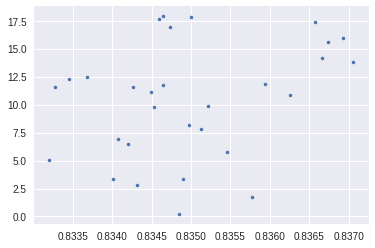

In [113]:
plt.plot(param_df['cv_score'], param_df['alpha'], '.')

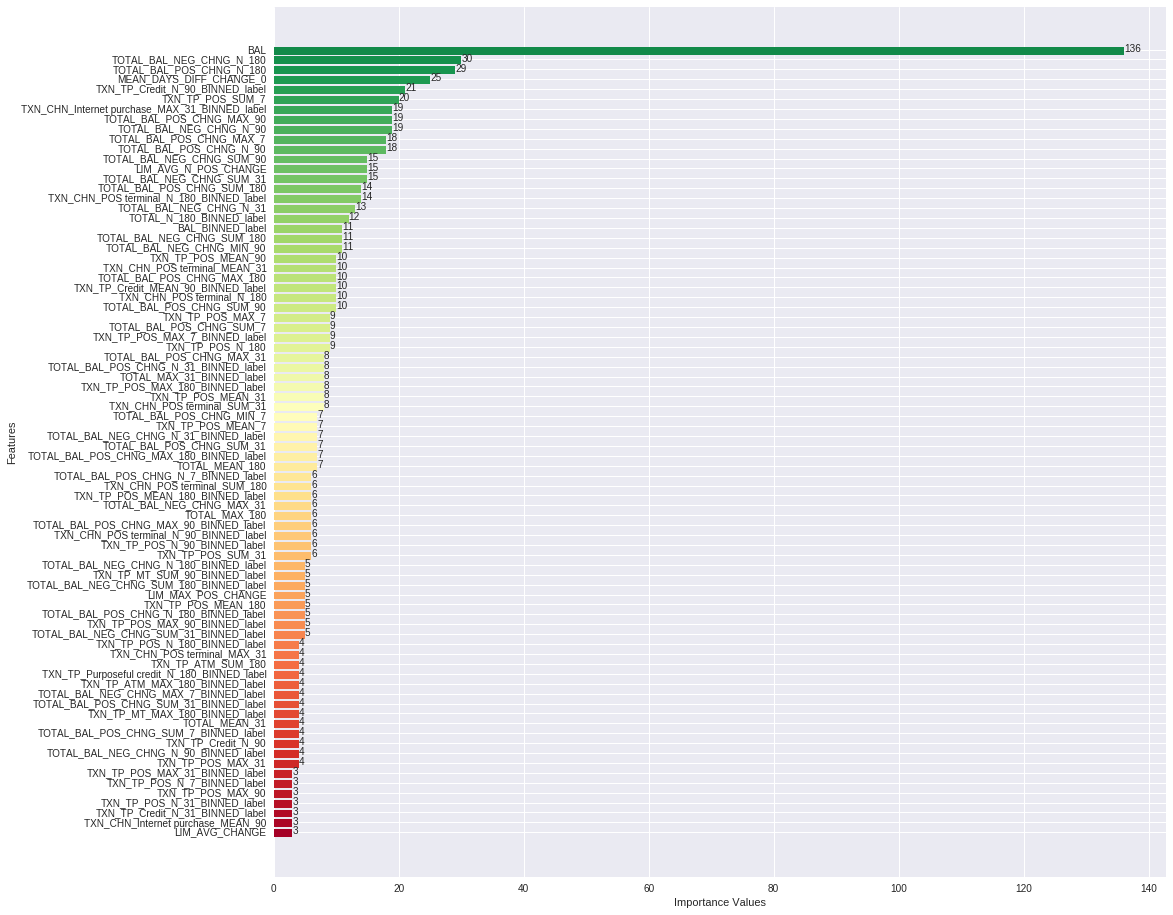

In [118]:
importances = c_model.xgb.booster().get_fscore()
f_names, f_values = zip(*sorted(importances.items(), key=lambda x: x[1]))

st_idx = len(f_names) / 2; end_idx = len(f_names) / 1;

fig = plt.figure(figsize=(16, 16))
plt.barh(np.arange(len(f_names[st_idx : end_idx])), f_values[st_idx : end_idx],
         color=[cm.RdYlGn(i * 3) for i in range(len(f_names[st_idx : end_idx]))])
fig.axes[0].set_yticklabels(f_names[st_idx : end_idx])
fig.axes[0].set_yticks(np.arange(len(f_names[st_idx : end_idx])) + 0.1)
fig.axes[0].set_xlabel('Importance Values')
fig.axes[0].set_ylabel('Features')
fig.axes[0].set_label('Feature Importances')
for i, v in enumerate(f_values[st_idx : end_idx]):
    fig.axes[0].text(v + .02, i - 0.1, v)
plt.show()

In [50]:
best_alpha = 8.403863
best_noise_std = 0.000695

In [56]:
## encode all Xy_train
## all indices
all_idx = Xy_train.index.copy().values
np.random.shuffle(all_idx)
## outer splits indices
outer_splits = np.array_split(all_idx, nfolds)
for c_col in binned_columns:
    n_col_name = '_'.join([c_col, target_col])
    Xy_train[n_col_name] = KFoldTargetEncoding(Xy_train[[c_col, target_col]],
                                               outer_splits,
                                               c_col,
                                               target_col,
                                               n_col_name,
                                               best_alpha,
                                               best_noise_std)
    Xy_test[n_col_name] = targetEncoding(Xy_train[[c_col, target_col]],
                                         Xy_test[[c_col]],
                                         c_col,
                                         target_col,
                                         best_alpha,
                                         best_noise_std)

In [59]:
c_config = dict(max_depth=5, learning_rate=.075, n_estimators=140, seed=seed,
                                 reg_lambda=950, scale_pos_weight=1.15, nthread=4, missing=np.nan,
                                 reg_alpha=500, subsample=0.7)

In [74]:
drop_cols_binned = ['label'] + filter(lambda x: re.match(u'.*_BINNED$', x), Xy_train.columns)
drop_cols_binned_target = ['label'] + filter(lambda x: re.match(u'.*_BINNED', x), Xy_train.columns)
drop_cols_y = ['label']
keep_target = filter(lambda x: re.match(u'.*_label', x), Xy_train.columns)

In [85]:
train_preds = []
test_preds = []

## no binned, no target
c_model_orig = XGBoostModel(c_config)
c_model_orig.train(Xy_train.drop(drop_cols_binned_target, axis=1), Xy_train.label)
train_preds.append(c_model_orig.test(Xy_train.drop(drop_cols_binned_target, axis=1)))
test_preds.append(c_model_orig.test(Xy_test.drop(drop_cols_binned_target, axis=1)))

## no binned
c_model_no_binned = XGBoostModel(c_config)
c_model_no_binned.train(Xy_train.drop(drop_cols_binned, axis=1), Xy_train.label)
train_preds.append(c_model_no_binned.test(Xy_train.drop(drop_cols_binned, axis=1)))
test_preds.append(c_model_no_binned.test(Xy_test.drop(drop_cols_binned, axis=1)))

## just target
c_model_target = XGBoostModel(c_config)
c_model_target.train(Xy_train[keep_target], Xy_train.label)
train_preds.append(c_model_target.test(Xy_train[keep_target]))
test_preds.append(c_model_target.test(Xy_test[keep_target]))

## all
c_model_all = XGBoostModel(c_config)
c_model_all.train(Xy_train.drop(drop_cols_y, axis=1), Xy_train.label)
train_preds.append(c_model_all.test(Xy_train.drop(drop_cols_y, axis=1)))
test_preds.append(c_model_all.test(Xy_test.drop(drop_cols_y, axis=1)))

In [86]:
evaluate(test_preds, Xy_test.label, 
         './BB', file_prefix='test_ens_enc', model_names=['orig', 'no_binned', 'target', 'all'])
evaluate(train_preds, Xy_train.label, 
         './BB', file_prefix='train_ens_enc', model_names=['orig', 'no_binned', 'target', 'all'])